In [216]:
import pandas as pd
import numpy as np
import seaborn as sns
import random
import datetime
import xgboost as xgb
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots
from plotly.offline import iplot
from datetime import date
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler

In [217]:
circuits = pd.read_csv('circuits.csv')
constructor_results = pd.read_csv('constructor_results.csv')
constructors_standings = pd.read_csv('constructor_standings.csv')
constructors = pd.read_csv('constructors.csv')
drivers_standings = pd.read_csv('driver_standings.csv')
drivers = pd.read_csv('drivers.csv')
lap_times = pd.read_csv('lap_times.csv')
pit_stops = pd.read_csv('pit_stops.csv')
qualifying = pd.read_csv('qualifying.csv')
races = pd.read_csv('races.csv')
results = pd.read_csv('results.csv')
seasons = pd.read_csv('seasons.csv')
status = pd.read_csv('status.csv')

In [218]:
def getMiliSeconds(time):
    try:
        if '.' in time:
            x = datetime.datetime.strptime(time, '%M:%S.%f')
        elif ',' in time:
            x = datetime.datetime.strptime(time, '%M:%S,%f')
        else:
            x = datetime.datetime.strptime(time, '%M:%S:%f')
        return datetime.timedelta(minutes = x.minute, seconds = x.second, microseconds = x.microsecond).total_seconds()
    except:
        x = datetime.datetime.strptime(str(time).split('.')[0],'%M:%S:%f')
        return datetime.timedelta(minutes = x.minute, seconds = x.second, microseconds = x.microsecond).total_seconds()

def timefn(x):
    if (x.find(':') != -1):
        return getMiliSeconds(x)
    else:
        return x

results['fastestLapTime'] = results['fastestLapTime'].replace('0','00:00.0')
qualifying['q1'] = qualifying['q1'].replace('0','00:00.0')
qualifying['q2'] = qualifying['q2'].replace('0','00:00.0')
qualifying['q3'] = qualifying['q3'].replace('0','00:00.0')

qualifying['q1'] = qualifying['q1'].apply(lambda x: getMiliSeconds(x))
qualifying['q2'] = qualifying['q2'].apply(lambda x: getMiliSeconds(x))
qualifying['q3'] = qualifying['q3'].apply(lambda x: getMiliSeconds(x))
lap_times['time'] = lap_times['time'].apply(lambda x: getMiliSeconds(x))
results['fastestLapTime'] = results['fastestLapTime'].apply(lambda x: getMiliSeconds(x))

pit_stops['duration'] = pit_stops['duration'].apply(lambda x: timefn(x))

drivers['fullName'] = drivers['forename'] + " " + drivers['surname']

In [219]:
data = pd.merge(results, qualifying, on = ['raceId', 'driverId','constructorId'], how = 'left')
data = pd.merge(data, races, on = 'raceId', how = 'left')
data = pd.merge(data, drivers, on = 'driverId', how = 'left')
data = pd.merge(data, constructors, on = 'constructorId', how = 'left')
data = pd.merge(data, circuits, on = 'circuitId', how = 'left')
data = data[['year', 'round', 'circuitId', 'circuitRef', 'name', 'name_x', 'lat', 'lng', 'resultId', 'raceId', 'driverId', 'driverRef',
             'fullName', 'dob', 'nationality_x', 'constructorId', 'constructorRef', 'name_y', 'nationality_y',
             'q1', 'q2', 'q3','grid', 'position_x', 'positionOrder', 'laps', 'milliseconds', 'fastestLap', 'rank', 'fastestLapTime',
             'fastestLapSpeed', 'statusId']]
data = data.rename(columns = {'round':'roundNum', 'name': 'circuitName', 'name_x': 'GrandPrix', 'nationality_x': 'driverNationality',
                              'name_y': 'constructor', 'nationality_y': 'constructorNationality', 'position_x': 'finishingPos', 
                              'rank':'fastestLapRank', 'milliseconds':'raceTime'}, inplace = False)
data = pd.merge(data, constructors_standings, on = ['constructorId', 'raceId'], how = 'left')
data = data.rename(columns = {'points': 'constructorPoints', 'position': 'constructorPosition', 'wins': 'constructorWins'}, inplace = False)
data = data.drop(['constructorStandingsId', 'positionText'], axis = 1, inplace = False)
data = pd.merge(data, drivers_standings, on = ['driverId', 'raceId'], how = 'left')
data = data.rename(columns = {'points': 'driverPoints', 'position': 'driverPosition', 'wins': 'driverWins'}, inplace = False)
data = data.drop(['driverStandingsId', 'positionText'], axis = 1, inplace = False)
pit_stop_count = pd.DataFrame(pit_stops.groupby(['raceId', 'driverId']).count())
data = pd.merge(data, pit_stop_count, on = ['raceId','driverId'], how = 'left')
data = data.drop(['lap', 'time', 'duration', 'milliseconds'], axis = 1, inplace = False)
pit_stops['duration'] = pit_stops['duration'].astype(float)
pit_stop_duration_mean = pit_stops.groupby(['raceId', 'driverId']).mean()
data = pd.merge(data, pit_stop_duration_mean, on = ['raceId','driverId'], how = 'left')
data = data.rename(columns = {'stop_x': 'pitStops', 'duration': 'pitStopDuration'}, inplace = False)
data = data.drop(['stop_y', 'lap', 'milliseconds'], axis = 1, inplace = False)
data['birth_year'] = pd.DatetimeIndex(data['dob']).year
data['dob'] =  data.year - data.birth_year
data = data.rename(columns = {'dob':'age'}, inplace = False)
data = data.drop(['birth_year'], axis = 1, inplace = False)
data = data[['year', 'roundNum', 'circuitId', 'circuitRef', 'circuitName', 'lat', 'lng', 'GrandPrix', 'resultId', 'raceId',
             'driverId', 'driverRef', 'fullName', 'age', 'driverNationality', 'constructorId', 'constructorRef',
             'constructor', 'constructorNationality', 'q1', 'q2', 'q3', 'grid', 'finishingPos', 'positionOrder',
             'laps', 'raceTime', 'fastestLap', 'fastestLapRank', 'fastestLapTime', 'fastestLapSpeed', 'statusId', 'pitStops', 'pitStopDuration',
             'constructorPoints', 'constructorPosition', 'constructorWins','driverPoints', 'driverPosition', 'driverWins']]

def agecorrection(x):
        if x < 10:
            return 59
        else:
            return x

data['age'] = data['age'].apply(lambda x: agecorrection(x))

data = data.sort_values(['year','roundNum'])
pd.set_option('display.max_columns', 500)
data.head()

year  roundNum  circuitId   circuitRef          circuitName      lat  \
20024  1950         1          9  silverstone  Silverstone Circuit  52.0786   
20025  1950         1          9  silverstone  Silverstone Circuit  52.0786   
20026  1950         1          9  silverstone  Silverstone Circuit  52.0786   
20027  1950         1          9  silverstone  Silverstone Circuit  52.0786   
20028  1950         1          9  silverstone  Silverstone Circuit  52.0786   

           lng           GrandPrix  resultId  raceId  driverId    driverRef  \
20024 -1.01694  British Grand Prix     20025     833       642       farina   
20025 -1.01694  British Grand Prix     20026     833       786      fagioli   
20026 -1.01694  British Grand Prix     20027     833       686  reg_parnell   
20027 -1.01694  British Grand Prix     20028     833       704    cabantous   
20028 -1.01694  British Grand Prix     20029     833       627       rosier   

             fullName  age driverNationality  constructorId constructorRef  \
20024     Nino Farina   59           Italian             51           alfa   
20025   Luigi Fagioli   52           Italian             51           alfa   
20026     Reg Parnell   59           British             51           alfa   
20027  Yves Cabantous   59            French            154           lago   
20028    Louis Rosier   59            French            154           lago   

       constructor constructorNationality  q1  q2  q3  grid  finishingPos  \
20024   Alfa Romeo                Italian NaN NaN NaN     1             1   
20025   Alfa Romeo                Italian NaN NaN NaN     2             2   
20026   Alfa Romeo                Italian NaN NaN NaN     4             3   
20027  Talbot-Lago                 French NaN NaN NaN     6             4   
20028  Talbot-Lago                 French NaN NaN NaN     9             5   

       positionOrder  laps  raceTime  fastestLap  fastestLapRank  \
20024              1    70   8003600           0               0   
20025              2    70   8006200           0               0   
20026              3    70   8055600           0               0   
20027              4    68         0           0               0   
20028              5    68         0           0               0   

       fastestLapTime  fastestLapSpeed  statusId  pitStops  pitStopDuration  \
20024             0.0              0.0         1       NaN              NaN   
20025             0.0              0.0         1       NaN              NaN   
20026             0.0              0.0         1       NaN              NaN   
20027             0.0              0.0        12       NaN              NaN   
20028             0.0              0.0        12       NaN              NaN   

       constructorPoints  constructorPosition  constructorWins  driverPoints  \
20024                NaN                  NaN              NaN           9.0   
20025                NaN                  NaN              NaN           6.0   
20026                NaN                  NaN              NaN           4.0   
20027                NaN                  NaN              NaN           3.0   
20028                NaN                  NaN              NaN           2.0   

       driverPosition  driverWins  
20024             1.0         1.0  
20025             2.0         0.0  
20026             3.0         0.0  
20027             4.0         0.0  
20028             5.0         0.0

In [220]:
data.tail()

year  roundNum  circuitId  circuitRef         circuitName      lat  \
24955  2020        17         24  yas_marina  Yas Marina Circuit  24.4672   
24956  2020        17         24  yas_marina  Yas Marina Circuit  24.4672   
24957  2020        17         24  yas_marina  Yas Marina Circuit  24.4672   
24958  2020        17         24  yas_marina  Yas Marina Circuit  24.4672   
24959  2020        17         24  yas_marina  Yas Marina Circuit  24.4672   

           lng             GrandPrix  resultId  raceId  driverId  \
24955  54.6031  Abu Dhabi Grand Prix     24961    1047       841   
24956  54.6031  Abu Dhabi Grand Prix     24962    1047       849   
24957  54.6031  Abu Dhabi Grand Prix     24963    1047       825   
24958  54.6031  Abu Dhabi Grand Prix     24964    1047       850   
24959  54.6031  Abu Dhabi Grand Prix     24965    1047       815   

               driverRef            fullName  age driverNationality  \
24955         giovinazzi  Antonio Giovinazzi   27           Italian   
24956             latifi     Nicholas Latifi   25          Canadian   
24957    kevin_magnussen     Kevin Magnussen   28            Danish   
24958  pietro_fittipaldi   Pietro Fittipaldi   24         Brazilian   
24959              perez        Sergio Pérez   30           Mexican   

       constructorId constructorRef   constructor constructorNationality  \
24955             51           alfa    Alfa Romeo                Italian   
24956              3       williams      Williams                British   
24957            210           haas  Haas F1 Team               American   
24958            210           haas  Haas F1 Team               American   
24959            211   racing_point  Racing Point                British   

         q1    q2   q3  grid  finishingPos  positionOrder  laps  raceTime  \
24955  97.1  98.2  0.0    14            16             16    54         0   
24956  98.4   0.0  0.0    18            17             17    54         0   
24957  97.9   0.0  0.0    20            18             18    54         0   
24958  98.2   0.0  0.0    17            19             19    53         0   
24959  96.0   0.0  0.0    19             0             20     8         0   

       fastestLap  fastestLapRank  fastestLapTime  fastestLapSpeed  statusId  \
24955          29               7           101.7          196.650        11   
24956          49              16           102.5          195.073        11   
24957          50              13           102.0          196.025        11   
24958          50               8           101.7          196.588        12   
24959           6              19           103.3          193.625         7   

       pitStops  pitStopDuration  constructorPoints  constructorPosition  \
24955       1.0        21.480000                8.0                  8.0   
24956       2.0        21.870500                0.0                 10.0   
24957       2.0        22.906000                3.0                  9.0   
24958       3.0        26.015667                3.0                  9.0   
24959       NaN              NaN              195.0                  4.0   

       constructorWins  driverPoints  driverPosition  driverWins  
24955              0.0           4.0            17.0         0.0  
24956              0.0           0.0            21.0         0.0  
24957              0.0           1.0            20.0         0.0  
24958              0.0           0.0            23.0         0.0  
24959              1.0         125.0             4.0         1.0

In [221]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24960 entries, 20024 to 24959
Data columns (total 40 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   year                    24960 non-null  int64  
 1   roundNum                24960 non-null  int64  
 2   circuitId               24960 non-null  int64  
 3   circuitRef              24960 non-null  object 
 4   circuitName             24960 non-null  object 
 5   lat                     24960 non-null  float64
 6   lng                     24960 non-null  float64
 7   GrandPrix               24960 non-null  object 
 8   resultId                24960 non-null  int64  
 9   raceId                  24960 non-null  int64  
 10  driverId                24960 non-null  int64  
 11  driverRef               24960 non-null  object 
 12  fullName                24960 non-null  object 
 13  age                     24960 non-null  int64  
 14  driverNationality       24960 non-

In [222]:
data.head()

year  roundNum  circuitId   circuitRef          circuitName      lat  \
20024  1950         1          9  silverstone  Silverstone Circuit  52.0786   
20025  1950         1          9  silverstone  Silverstone Circuit  52.0786   
20026  1950         1          9  silverstone  Silverstone Circuit  52.0786   
20027  1950         1          9  silverstone  Silverstone Circuit  52.0786   
20028  1950         1          9  silverstone  Silverstone Circuit  52.0786   

           lng           GrandPrix  resultId  raceId  driverId    driverRef  \
20024 -1.01694  British Grand Prix     20025     833       642       farina   
20025 -1.01694  British Grand Prix     20026     833       786      fagioli   
20026 -1.01694  British Grand Prix     20027     833       686  reg_parnell   
20027 -1.01694  British Grand Prix     20028     833       704    cabantous   
20028 -1.01694  British Grand Prix     20029     833       627       rosier   

             fullName  age driverNationality  constructorId constructorRef  \
20024     Nino Farina   59           Italian             51           alfa   
20025   Luigi Fagioli   52           Italian             51           alfa   
20026     Reg Parnell   59           British             51           alfa   
20027  Yves Cabantous   59            French            154           lago   
20028    Louis Rosier   59            French            154           lago   

       constructor constructorNationality  q1  q2  q3  grid  finishingPos  \
20024   Alfa Romeo                Italian NaN NaN NaN     1             1   
20025   Alfa Romeo                Italian NaN NaN NaN     2             2   
20026   Alfa Romeo                Italian NaN NaN NaN     4             3   
20027  Talbot-Lago                 French NaN NaN NaN     6             4   
20028  Talbot-Lago                 French NaN NaN NaN     9             5   

       positionOrder  laps  raceTime  fastestLap  fastestLapRank  \
20024              1    70   8003600           0               0   
20025              2    70   8006200           0               0   
20026              3    70   8055600           0               0   
20027              4    68         0           0               0   
20028              5    68         0           0               0   

       fastestLapTime  fastestLapSpeed  statusId  pitStops  pitStopDuration  \
20024             0.0              0.0         1       NaN              NaN   
20025             0.0              0.0         1       NaN              NaN   
20026             0.0              0.0         1       NaN              NaN   
20027             0.0              0.0        12       NaN              NaN   
20028             0.0              0.0        12       NaN              NaN   

       constructorPoints  constructorPosition  constructorWins  driverPoints  \
20024                NaN                  NaN              NaN           9.0   
20025                NaN                  NaN              NaN           6.0   
20026                NaN                  NaN              NaN           4.0   
20027                NaN                  NaN              NaN           3.0   
20028                NaN                  NaN              NaN           2.0   

       driverPosition  driverWins  
20024             1.0         1.0  
20025             2.0         0.0  
20026             3.0         0.0  
20027             4.0         0.0  
20028             5.0         0.0

In [223]:
data = data.replace(np.nan, 0)

In [224]:
data_10 = data.copy()
data_10 = data_10[data_10['year'] > 2009]
data_10.head()

year  roundNum  circuitId circuitRef                    circuitName  \
20320  2010         1          3    bahrain  Bahrain International Circuit   
20321  2010         1          3    bahrain  Bahrain International Circuit   
20322  2010         1          3    bahrain  Bahrain International Circuit   
20323  2010         1          3    bahrain  Bahrain International Circuit   
20324  2010         1          3    bahrain  Bahrain International Circuit   

           lat      lng           GrandPrix  resultId  raceId  driverId  \
20320  26.0325  50.5106  Bahrain Grand Prix     20323     337         4   
20321  26.0325  50.5106  Bahrain Grand Prix     20324     337        13   
20322  26.0325  50.5106  Bahrain Grand Prix     20325     337         1   
20323  26.0325  50.5106  Bahrain Grand Prix     20326     337        20   
20324  26.0325  50.5106  Bahrain Grand Prix     20327     337         3   

      driverRef          fullName  age driverNationality  constructorId  \
20320    alonso   Fernando Alonso   29           Spanish              6   
20321     massa      Felipe Massa   29         Brazilian              6   
20322  hamilton    Lewis Hamilton   25           British              1   
20323    vettel  Sebastian Vettel   23            German              9   
20324   rosberg      Nico Rosberg   25            German            131   

      constructorRef constructor constructorNationality     q1     q2     q3  \
20320        ferrari     Ferrari                Italian  114.6  114.2  114.6   
20321        ferrari     Ferrari                Italian  115.3  114.3  114.2   
20322        mclaren     McLaren                British  115.3  114.7  115.2   
20323       red_bull    Red Bull               Austrian  115.0  113.9  114.1   
20324       mercedes    Mercedes                 German  115.5  114.7  115.2   

       grid  finishingPos  positionOrder  laps  raceTime  fastestLap  \
20320     3             1              1    49   5960396          45   
20321     2             2              2    49   5976495          38   
20322     4             3              3    49   5983578          42   
20323     1             4              4    49   5999195          32   
20324     5             5              5    49   6000609          45   

       fastestLapRank  fastestLapTime  fastestLapSpeed  statusId  pitStops  \
20320               1           118.3          191.706         1       0.0   
20321               5           119.7          189.392         1       0.0   
20322               4           119.6          189.665         1       0.0   
20323              12           120.2          188.627         1       0.0   
20324              13           120.2          188.599         1       0.0   

       pitStopDuration  constructorPoints  constructorPosition  \
20320              0.0               43.0                  1.0   
20321              0.0               43.0                  1.0   
20322              0.0               21.0                  2.0   
20323              0.0               16.0                  4.0   
20324              0.0               18.0                  3.0   

       constructorWins  driverPoints  driverPosition  driverWins  
20320              1.0          25.0             1.0         1.0  
20321              1.0          18.0             2.0         0.0  
20322              0.0          15.0             3.0         0.0  
20323              0.0          12.0             4.0         0.0  
20324              0.0          10.0             5.0         0.0

# Exploratory Data Analysis

Data analysis of the various race cuircuits, constructors and drivers

In [225]:
tracks = [{'lat': circuits['lat'], 'lon': circuits['lng'],
         'marker': {'color': 'orangered','line': {'color': 'black', 'width': 0.5}, 'size': 10,
                    'sizemode': 'diameter'}, 'text': '0.387', 'type': 'scattergeo'},]

layout = go.Layout(title = 'Circuits World Location', showlegend = False,
                   geo = dict(scope='world', projection = dict( type = 'natural earth'), showland = True,
                              landcolor = 'navajowhite', subunitwidth = 1, countrywidth = 1, 
                              subunitcolor = "navajowhite", countrycolor = "navajowhite"),
                   paper_bgcolor = 'white', plot_bgcolor = 'lightgrey')

fig =  go.Figure(layout = layout, data = tracks)
fig.update_layout(margin = dict(l = 60, r = 60, t = 50, b = 50))
iplot(fig, validate = False)

In [226]:
races_count = races['name'].value_counts()
trace = go.Pie(labels = races_count.index, values = races_count.values, hole = 0.6, textinfo = "none")
layout = go.Layout(title = 'Most number of Grand Prix', paper_bgcolor = 'gainsboro')
fig = go.Figure(data = [trace], layout = layout)
fig.update_layout(margin = dict(l = 60, r = 60, t = 50, b = 50))
iplot(fig, filename = "plotting-library")

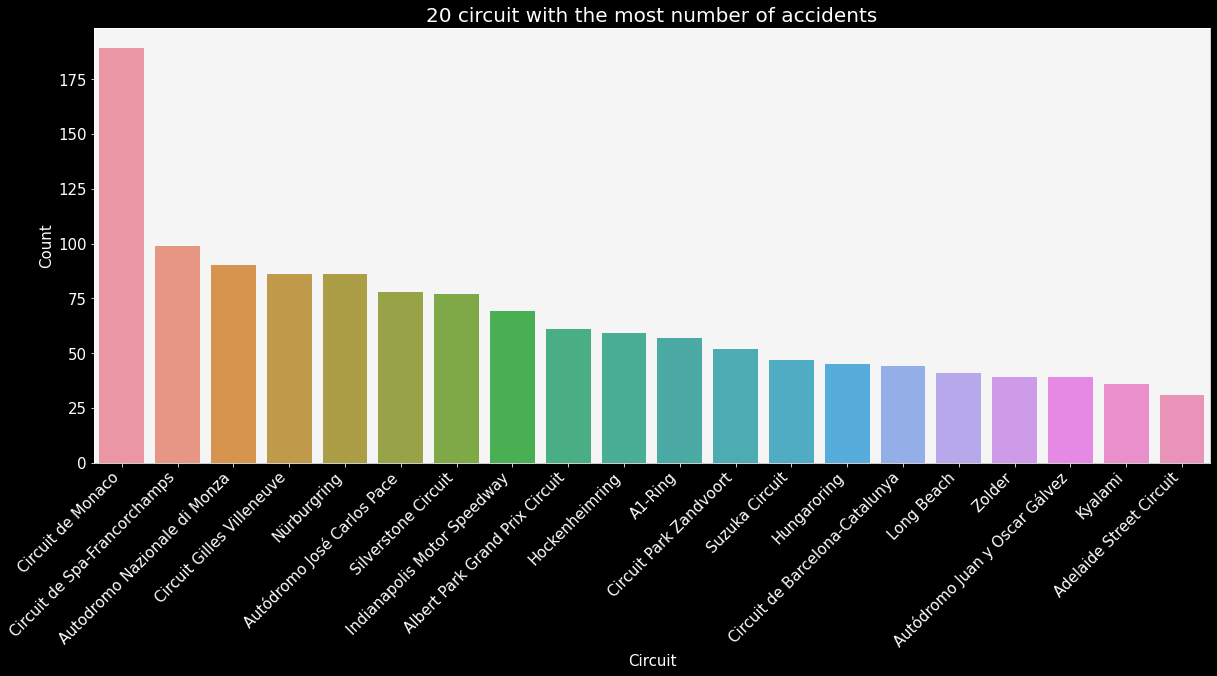

In [227]:
dangerousCircuits = data.loc[(data['statusId'] == 3) | (data['statusId'] == 4)]['circuitName'].value_counts()[:20]

plt.style.use('dark_background')
fig, axs = plt.subplots(figsize=(20, 8))
axs.tick_params(axis="x", labelsize = 15)
axs.tick_params(axis="y", labelsize = 15)
axs.set_facecolor('whitesmoke')

sns.barplot(dangerousCircuits.index, dangerousCircuits.values)
plt.title("20 circuit with the most number of accidents", fontsize = 20)
plt.xlabel('Circuit', fontsize = 15)
plt.ylabel('Count', fontsize = 15)
plt.xticks(rotation = 45, ha = 'right')
plt.show()

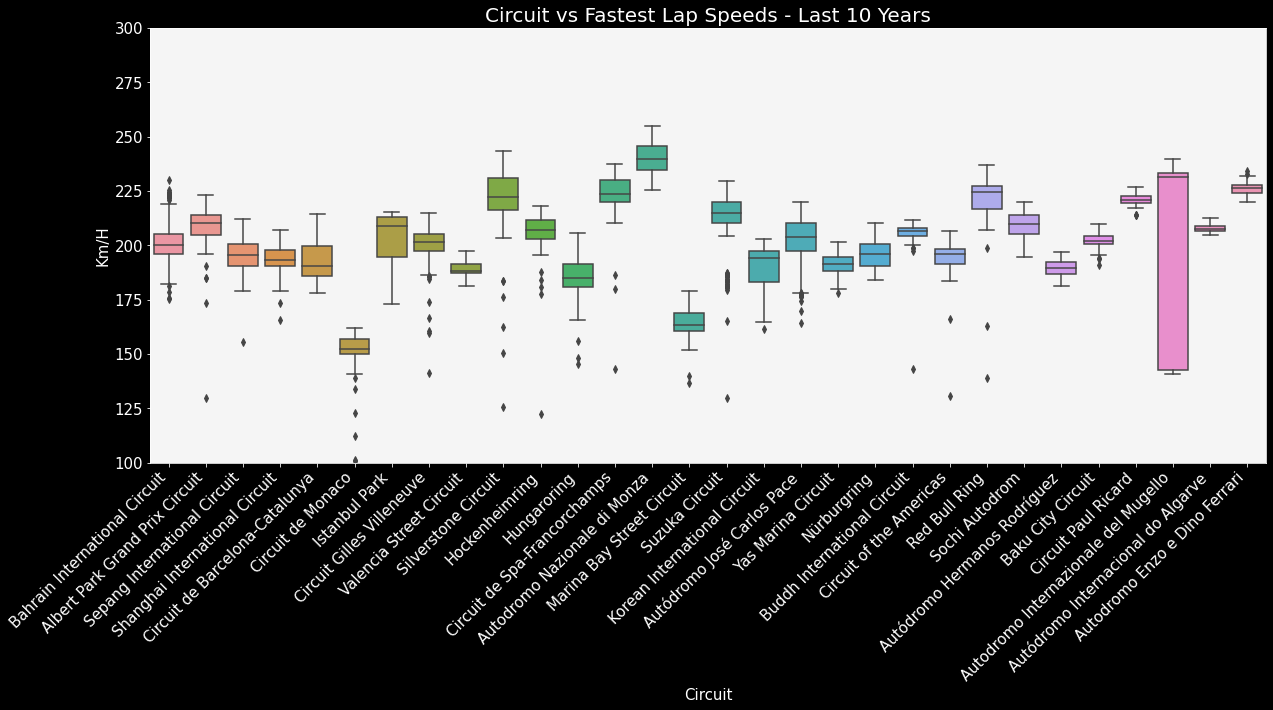

In [228]:
plt.style.use('dark_background')
fig, axs = plt.subplots(figsize=(20, 8))
axs.tick_params(axis="x", labelsize = 15)
axs.tick_params(axis="y", labelsize = 15)
axs.set_facecolor('whitesmoke')

sns.boxplot(x = 'circuitName', y = 'fastestLapSpeed', data = data_10)
plt.ylim(100, 300)
plt.title("Circuit vs Fastest Lap Speeds - Last 10 Years", fontsize = 20)
plt.xlabel('Circuit', fontsize = 15)
plt.ylabel('Km/H', fontsize = 15)
plt.xticks(rotation = 45, ha = 'right')
plt.show()

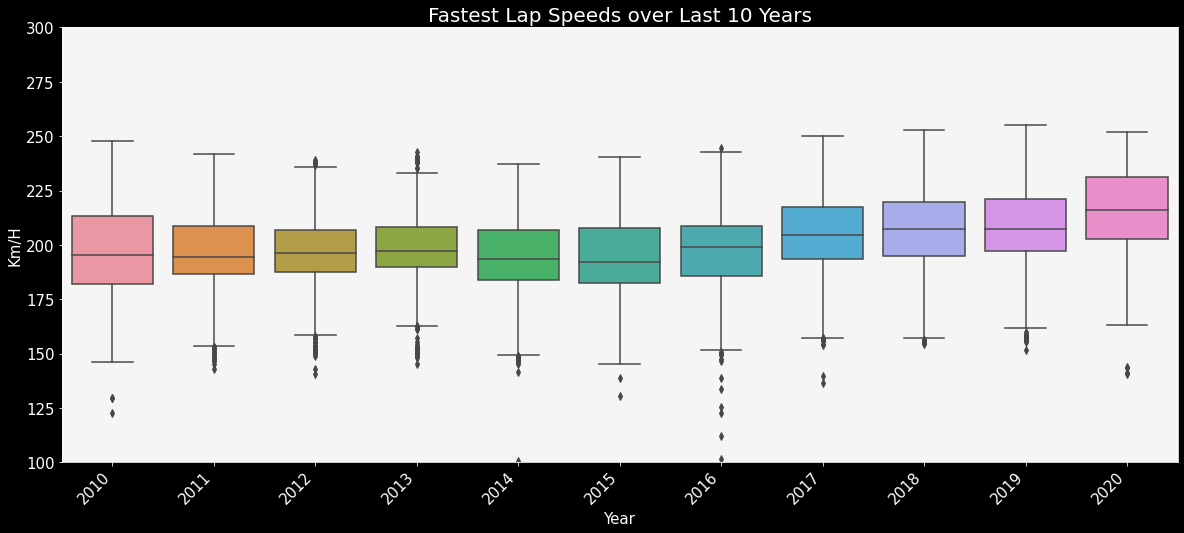

In [229]:
plt.style.use('dark_background')
fig, axs = plt.subplots(figsize = (20, 8))
axs.tick_params(axis = "x", labelsize = 15)
axs.tick_params(axis = "y", labelsize = 15)
axs.set_facecolor('whitesmoke')

sns.boxplot(x = 'year', y = 'fastestLapSpeed', data = data_10)
plt.ylim(100, 300)
plt.title("Fastest Lap Speeds over Last 10 Years", fontsize = 20)
plt.xlabel('Year', fontsize = 15)
plt.ylabel('Km/H', fontsize = 15)
plt.xticks(rotation = 45, ha = 'right')
plt.show()

We can see that the lap speeds have increased obviously over the last 10 years. However, we see that post 2014, the average speeds have risen faster per year post the 1.6 V6 Turbo Engine rule change. Could be due to the MGU-K and MGU-H introduction 

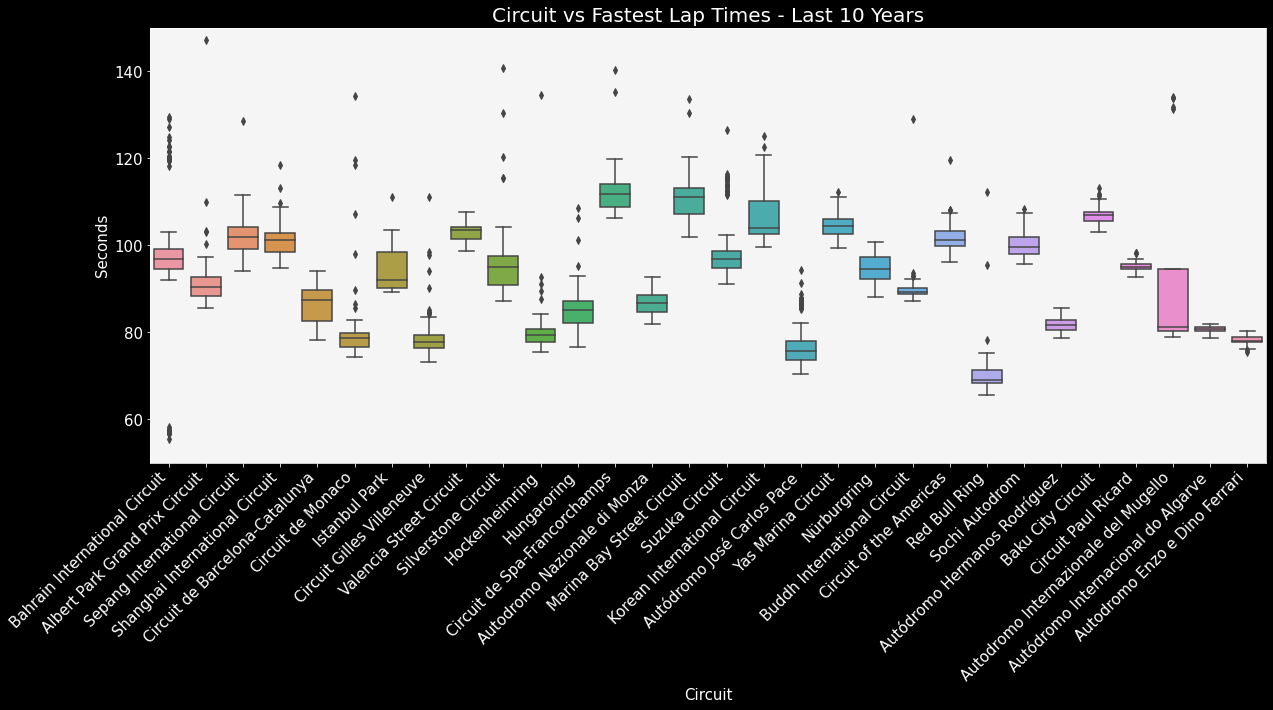

In [230]:
fig, axs = plt.subplots(figsize = (20, 8))
axs.tick_params(axis = "x", labelsize = 15)
axs.tick_params(axis = "y", labelsize = 15)
axs.set_facecolor('whitesmoke')

sns.boxplot(x = 'circuitName', y = 'fastestLapTime', data = data_10)
plt.ylim(50, 150)
plt.title("Circuit vs Fastest Lap Times - Last 10 Years", fontsize = 20)
plt.xlabel('Circuit', fontsize = 15)
plt.ylabel('Seconds', fontsize = 15)
plt.xticks(rotation = 45, ha = 'right')
plt.show()

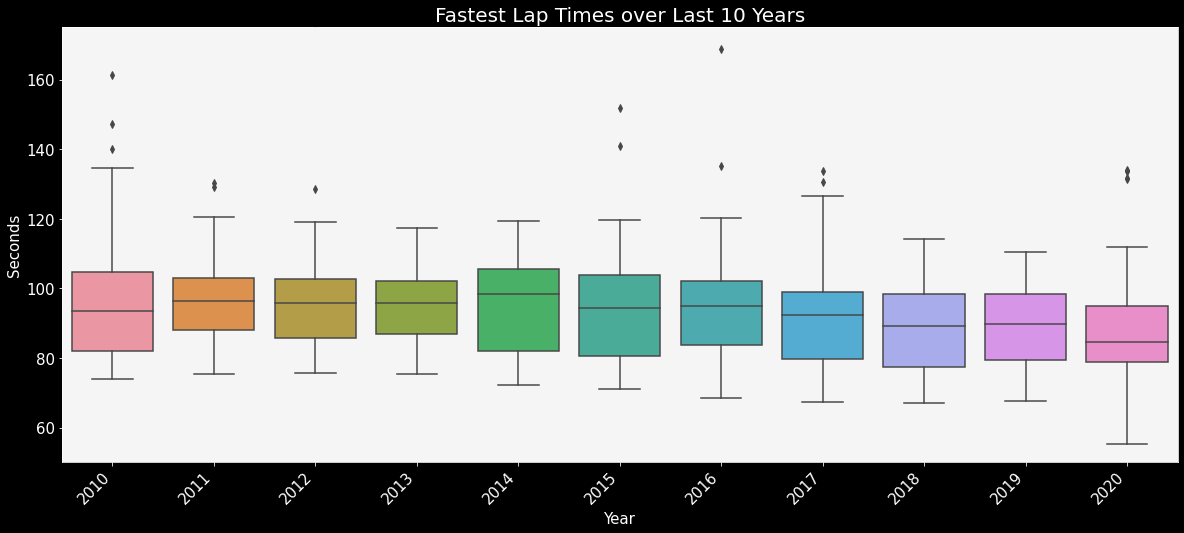

In [231]:
plt.style.use('dark_background')
fig, axs = plt.subplots(figsize = (20, 8))
axs.tick_params(axis = "x", labelsize = 15)
axs.tick_params(axis = "y", labelsize = 15)
axs.set_facecolor('whitesmoke')

sns.boxplot(x = 'year', y = 'fastestLapTime', data = data_10)
plt.ylim(50, 175)
plt.title("Fastest Lap Times over Last 10 Years", fontsize = 20)
plt.xlabel('Year', fontsize = 15)
plt.ylabel('Seconds', fontsize = 15)
plt.xticks(rotation = 45, ha = 'right')
plt.show()

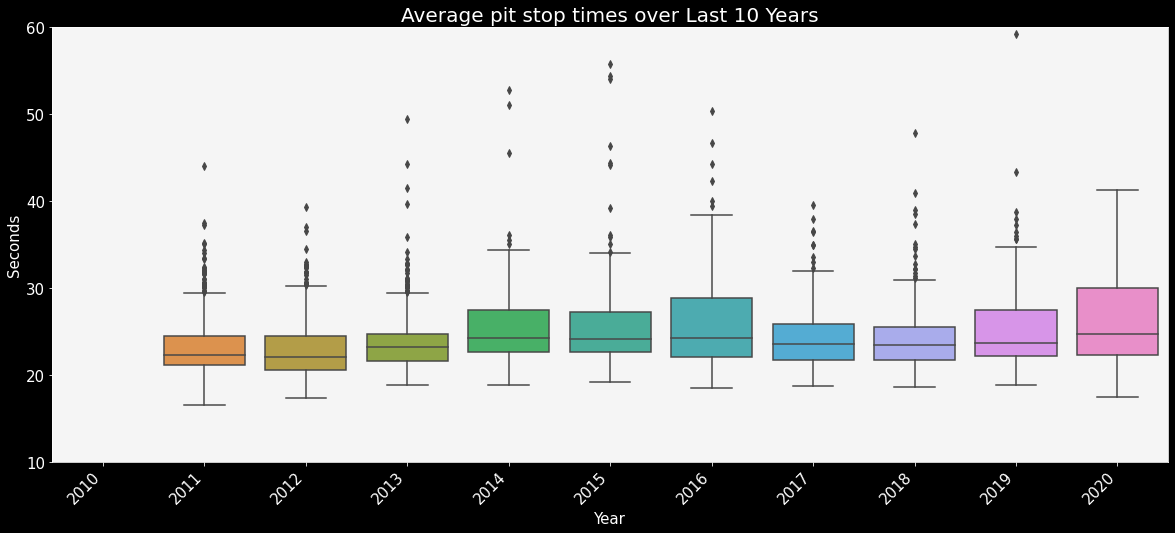

In [232]:
plt.style.use('dark_background')
fig, axs = plt.subplots(figsize = (20, 8))
axs.tick_params(axis = "x", labelsize = 15)
axs.tick_params(axis = "y", labelsize = 15)
axs.set_facecolor('whitesmoke')

sns.boxplot(x = 'year', y = 'pitStopDuration', data = data_10)
plt.ylim(10, 60)
plt.title("Average pit stop times over Last 10 Years", fontsize = 20)
plt.xlabel('Year',fontsize = 15)
plt.ylabel('Seconds', fontsize = 15)
plt.xticks(rotation = 45, ha = 'right')
plt.show()

Oddly, average pit stop durations have increased over the years

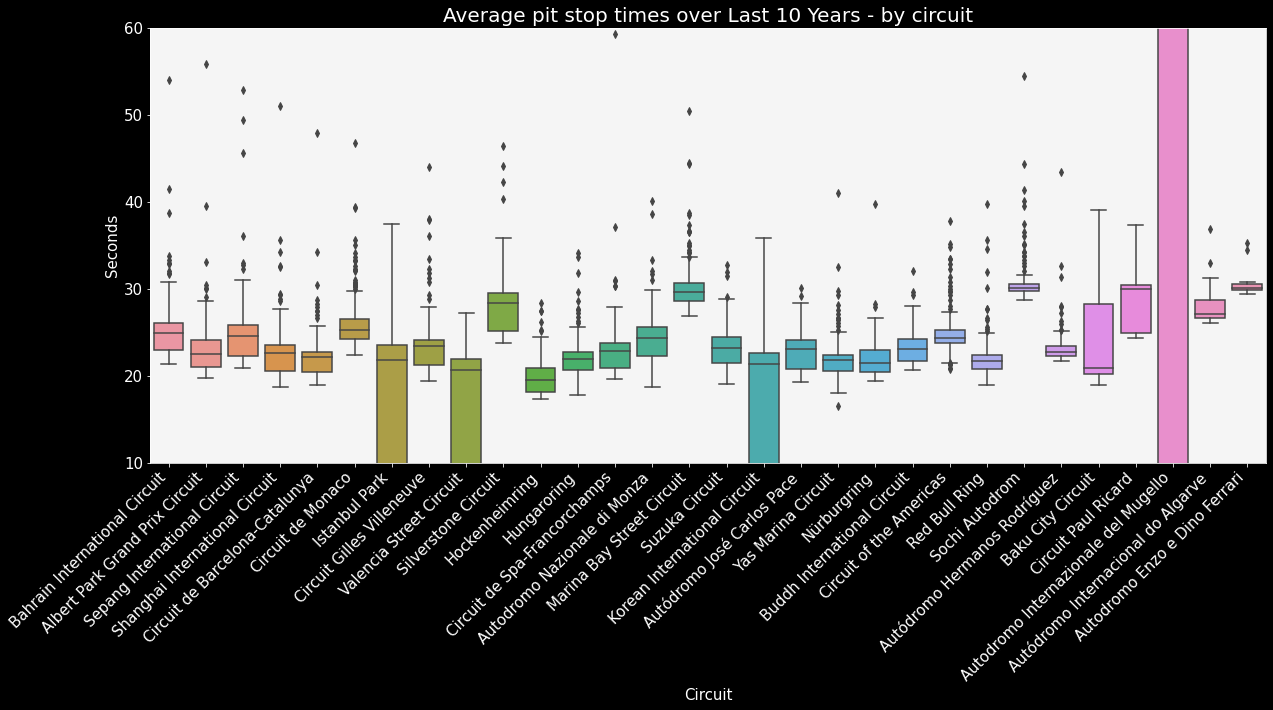

In [233]:
plt.style.use('dark_background')
fig, axs = plt.subplots(figsize = (20, 8))
axs.tick_params(axis = "x", labelsize = 15)
axs.tick_params(axis = "y", labelsize = 15)
axs.set_facecolor('whitesmoke')

sns.boxplot(x = 'circuitName', y = 'pitStopDuration', data = data_10)
plt.ylim(10, 60)
plt.title("Average pit stop times over Last 10 Years - by circuit", fontsize = 20)
plt.xlabel('Circuit',fontsize = 15)
plt.ylabel('Seconds', fontsize = 15)
plt.xticks(rotation = 45, ha = 'right')
plt.show()

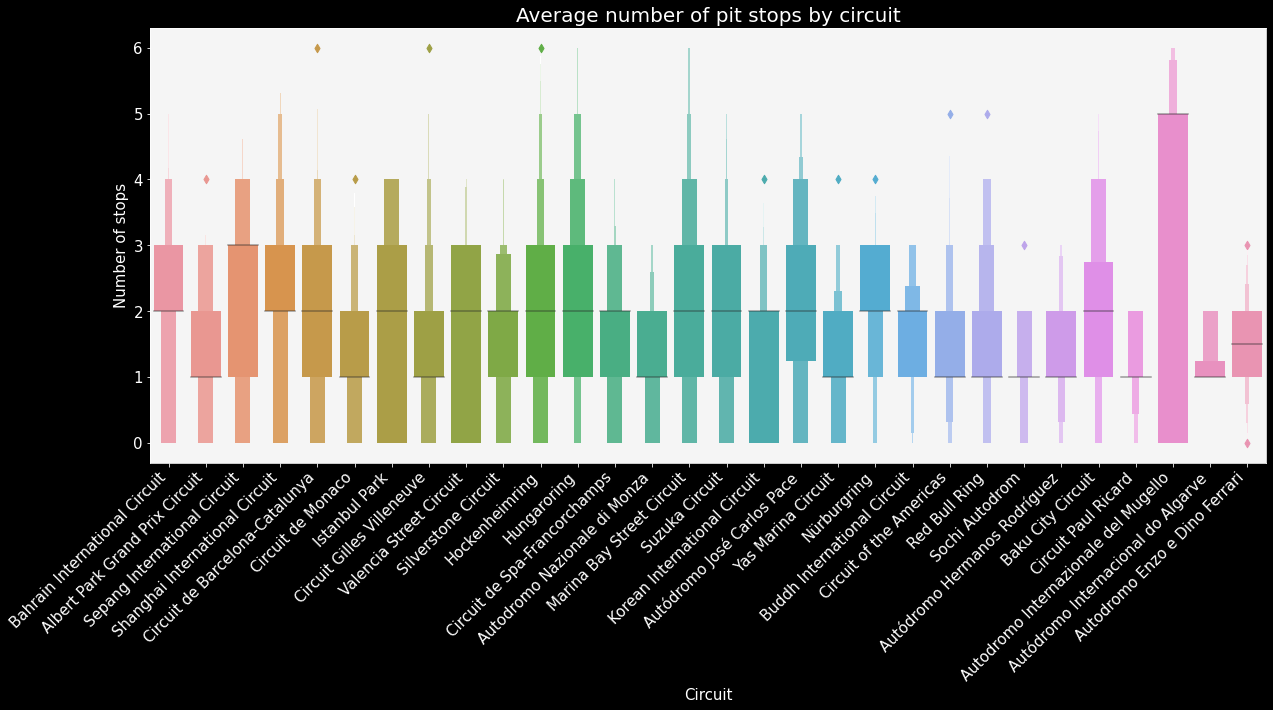

In [234]:
plt.style.use('dark_background')
fig, axs = plt.subplots(figsize = (20, 8))
axs.tick_params(axis = "x", labelsize = 15)
axs.tick_params(axis = "y", labelsize = 15)
axs.set_facecolor('whitesmoke')

sns.boxenplot(x = 'circuitName', y = 'pitStops', data = data_10)
plt.title("Average number of pit stops by circuit", fontsize = 20)
plt.xlabel('Circuit',fontsize = 15)
plt.ylabel('Number of stops', fontsize = 15)
plt.xticks(rotation = 45, ha = 'right')
plt.show()

In [235]:
constructors_count = data.drop_duplicates(subset = ["constructorId"])
constructors_count = constructors_count['constructorNationality'].value_counts()
trace = go.Pie(labels = constructors_count.index, values = constructors_count.values, hole = 0.6,textinfo = "none")
layout = go.Layout(title = 'Percentage of Constructors by Nationality', paper_bgcolor = 'gainsboro')
fig = go.Figure(data = [trace], layout = layout)
fig.update_layout(margin = dict(l = 60, r = 60, t = 50, b = 50))
iplot(fig, filename = "plotting-library")

In [236]:
constructors_count = data.drop_duplicates(subset = ["constructorId"])
fig = px.sunburst(constructors_count, path = ['constructorNationality', 'constructor'])
fig.update_layout(margin = dict(l = 60, r = 60, t = 50, b = 50))
fig.update_layout(go.Layout(title = 'Teams by Nationality', paper_bgcolor = 'gainsboro'))

In [237]:
drivers_count = data.drop_duplicates(subset = ["driverId"])
drivers_count = drivers_count['driverNationality'].value_counts()
trace = go.Pie(labels = drivers_count.index, values = drivers_count.values, hole = 0.6,textinfo = "none")
layout = go.Layout(title = 'Percentage of Drivers by Nationality', paper_bgcolor = 'gainsboro')
fig = go.Figure(data = [trace], layout = layout)
fig.update_layout(margin = dict(l = 60, r = 60, t = 50, b = 50))
iplot(fig, filename = "plotting-library")

In [240]:
driver_age = data.drop_duplicates(subset = ["driverId"])
driver_age = driver_age[driver_age['year'] >= 1968]
driver_age_dist_count = driver_age['age'].value_counts()

trace = go.Pie(labels = driver_age_dist_count.index, values = driver_age_dist_count.values, hole = 0.6,textinfo = "none")
layout = go.Layout(title = 'Age wise race debutants', paper_bgcolor = 'gainsboro')
fig = go.Figure(data = [trace], layout = layout)
fig.update_layout(margin = dict(l = 60, r = 60, t = 50, b = 50))
iplot(fig, filename = "plotting-library")

young_debutants = driver_age[driver_age['age'] <= 21]
young_debutants = young_debutants[['fullName', 'age', 'year', 'GrandPrix', 'constructor']]
fig = px.sunburst(young_debutants, path = ['age', 'fullName'])
fig.update_layout(margin = dict(l = 60, r = 60, t = 50, b = 50))
fig.update_layout(go.Layout(title = 'Young Debutants', paper_bgcolor = 'gainsboro'))

# Hamilton's Performance Analysis

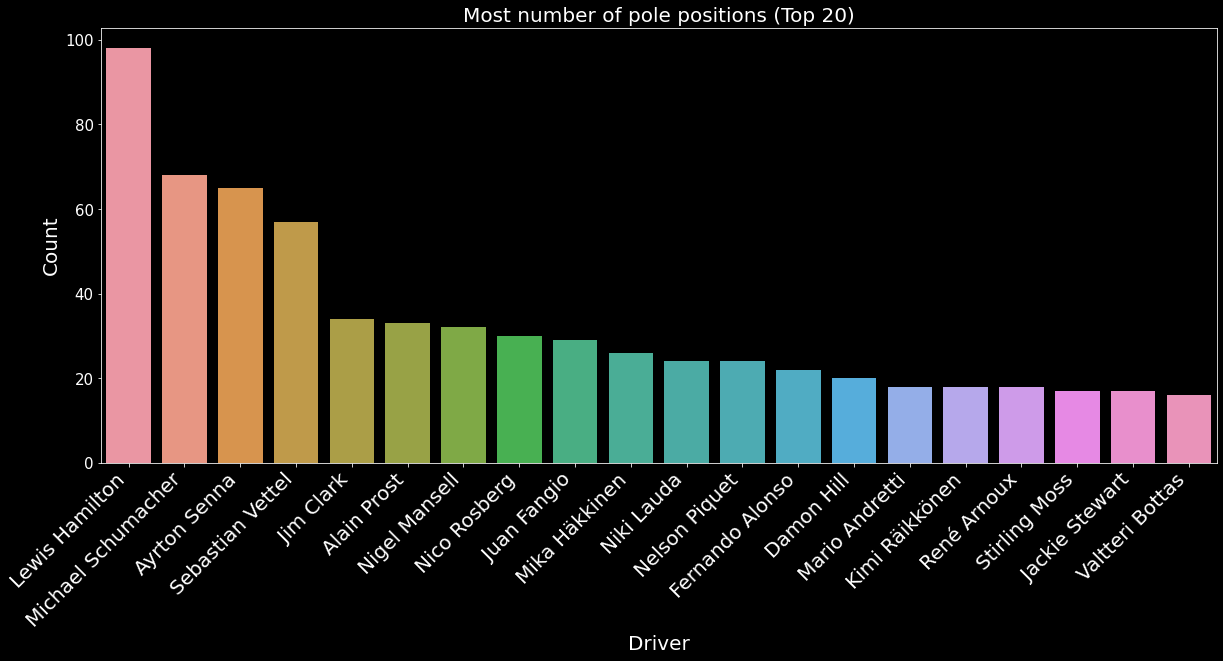

In [81]:
polesitters = data.loc[data['grid'] == 1].groupby('fullName')['grid'].count().sort_values(ascending = False)[:20]

fig, axs = plt.subplots(figsize = (20, 8))
axs.tick_params(axis = "x", labelsize = 20)
axs.tick_params(axis = "y", labelsize = 15)

sns.barplot(list(polesitters.index), list(polesitters.values))
axs.set_facecolor('k')
axs.patch.set_alpha(0.9)
plt.title("Most number of pole positions (Top 20)", fontsize = 20)
plt.ylabel('Count', fontsize = 20)
plt.xticks(rotation = 45, ha = 'right')
plt.xlabel('Driver', fontsize = 20)
plt.show()

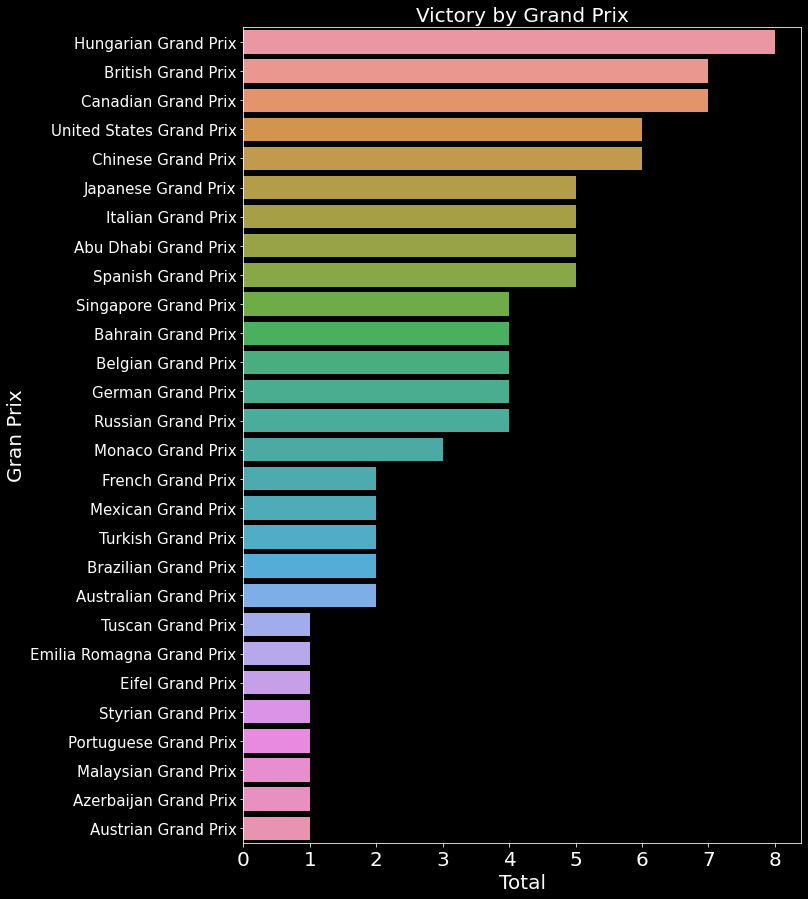

In [82]:
ham_wins = data.loc[(data['driverId'] == 1) & (data['positionOrder'] == 1)].groupby('GrandPrix')['driverId'].count().sort_values(ascending = False)

fig, axs = plt.subplots(figsize = (10, 15))
axs.tick_params(axis = "x", labelsize = 20)
axs.tick_params(axis = "y", labelsize = 15)

sns.barplot(list(ham_wins.values), list(ham_wins.index))
axs.set_facecolor('k')
axs.patch.set_alpha(0.9)
plt.title("Victory by Grand Prix", fontsize = 20)
plt.ylabel('Gran Prix', fontsize = 20)
plt.xlabel('Total', fontsize = 20)
plt.show()

Interestingly HAM has won more Hungarian GPs than on homeground at Silverstone (British GP)

Let's see how he performs compared to some other legends

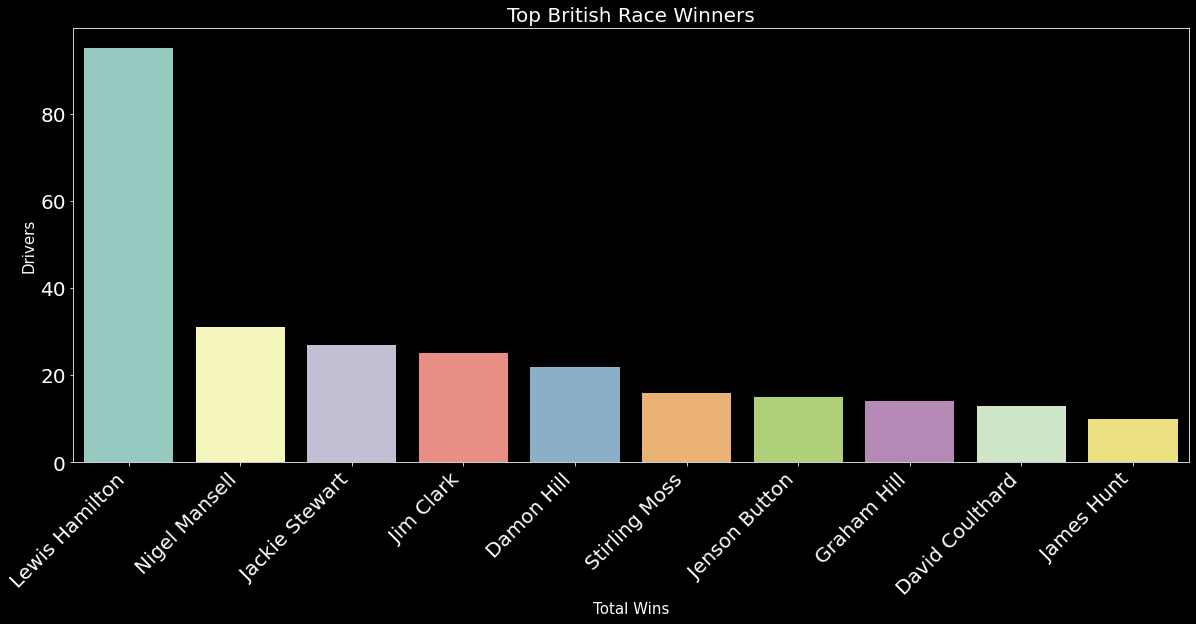

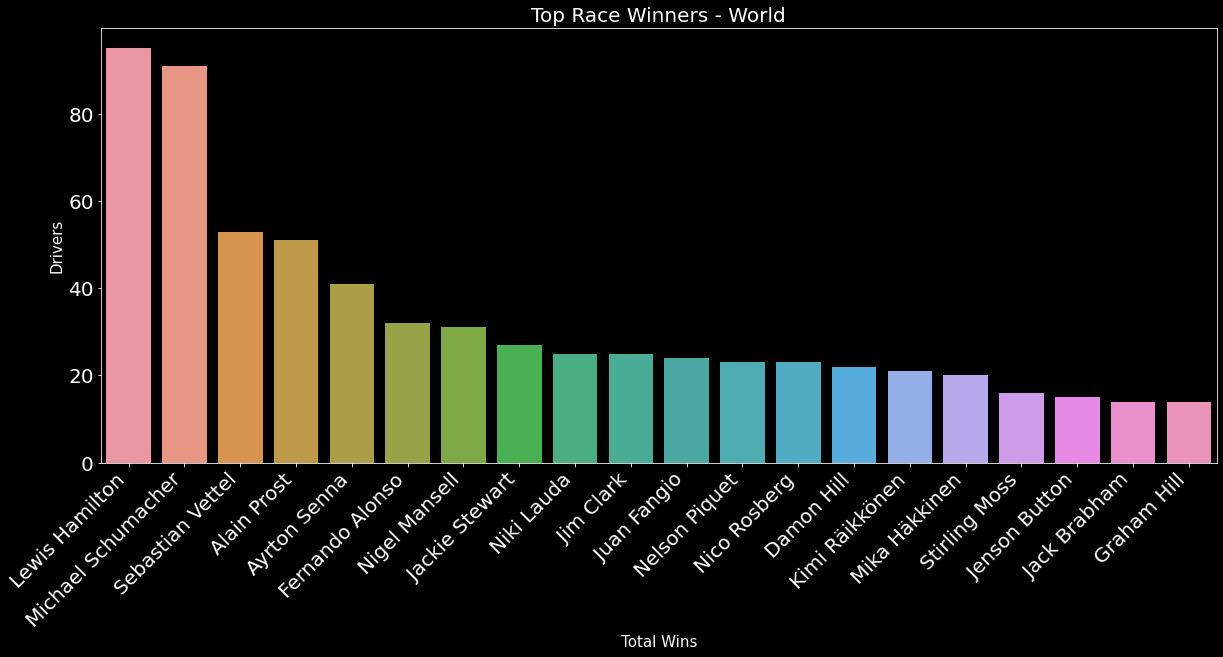

In [83]:
topBritish = data.loc[(data['driverNationality'] == 'British') & 
                                       (data['positionOrder'] == 1)].groupby('fullName')['raceId'].count().sort_values(ascending=False)[:10]

topWorld = data.loc[(data['positionOrder'] == 1)].groupby('fullName')['raceId'].count().sort_values(ascending=False)[:20]

fig, axs = plt.subplots(figsize = (20, 8))
axs.tick_params(axis = "x", labelsize = 20)
axs.tick_params(axis = "y", labelsize = 20)

sns.barplot(list(topBritish.index), list(topBritish.values))
axs.set_facecolor('k')
axs.patch.set_alpha(0.9)
plt.title("Top British Race Winners", fontsize=20)
plt.ylabel('Drivers', fontsize = 15)
plt.xlabel('Total Wins', fontsize = 15)
plt.xticks(rotation = 45, ha = 'right')
plt.show()

fig, axs = plt.subplots(figsize = (20, 8))
axs.tick_params(axis = "x", labelsize = 20)
axs.tick_params(axis = "y", labelsize = 20)

sns.barplot(list(topWorld.index), list(topWorld.values))
axs.set_facecolor('k')
axs.patch.set_alpha(0.9)
plt.xticks(rotation = 45, ha = 'right')
plt.title("Top Race Winners - World", fontsize = 20)
plt.ylabel('Drivers', fontsize = 15)
plt.xlabel('Total Wins', fontsize = 15)
plt.show()

Hamilton has surpassed Schumacher in the most number of wins.

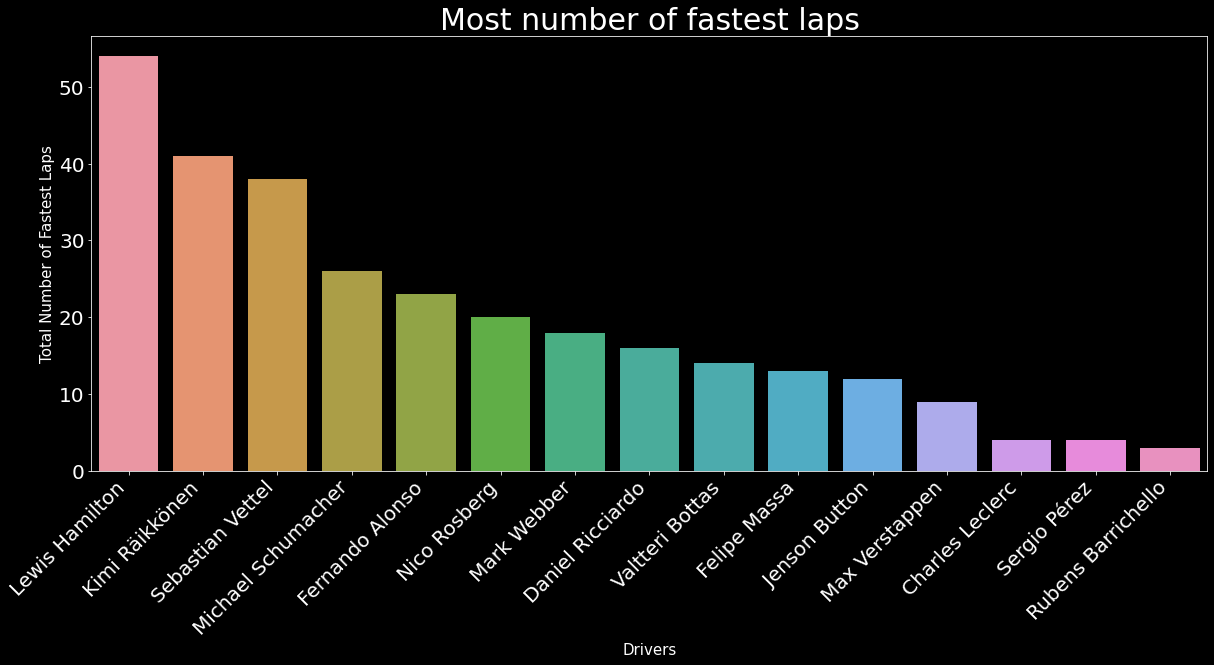

In [84]:
f_laps = data.copy()
f_laps = f_laps[['raceId', 'year', 'fullName', 'fastestLapTime']].sort_values(['year', 'raceId'])
f_laps = f_laps[f_laps['fastestLapTime'] != 0]
f_laps = f_laps.drop(['year'], axis = 1)

y = range(1, data.raceId.max()+1)
counts = pd.DataFrame()
for x in y:
    counts = counts.append(f_laps.loc[f_laps['raceId'] == x].sort_values(['fastestLapTime'])[:1])

counts = counts.groupby('fullName').count().sort_values(['fastestLapTime'], ascending = False)[:15]
counts
fig, axs = plt.subplots(figsize = (20, 8))
axs.tick_params(axis = "x", labelsize = 20)
axs.tick_params(axis = "y", labelsize = 20)

sns.barplot(list(counts.index), counts['fastestLapTime'])
axs.set_facecolor('k')
axs.patch.set_alpha(0.9)
plt.xticks(rotation = 45, ha = 'right')
plt.title("Most number of fastest laps", fontsize = 30)
plt.ylabel('Total Number of Fastest Laps', fontsize = 15)
plt.xlabel('Drivers', fontsize = 15)
plt.show()

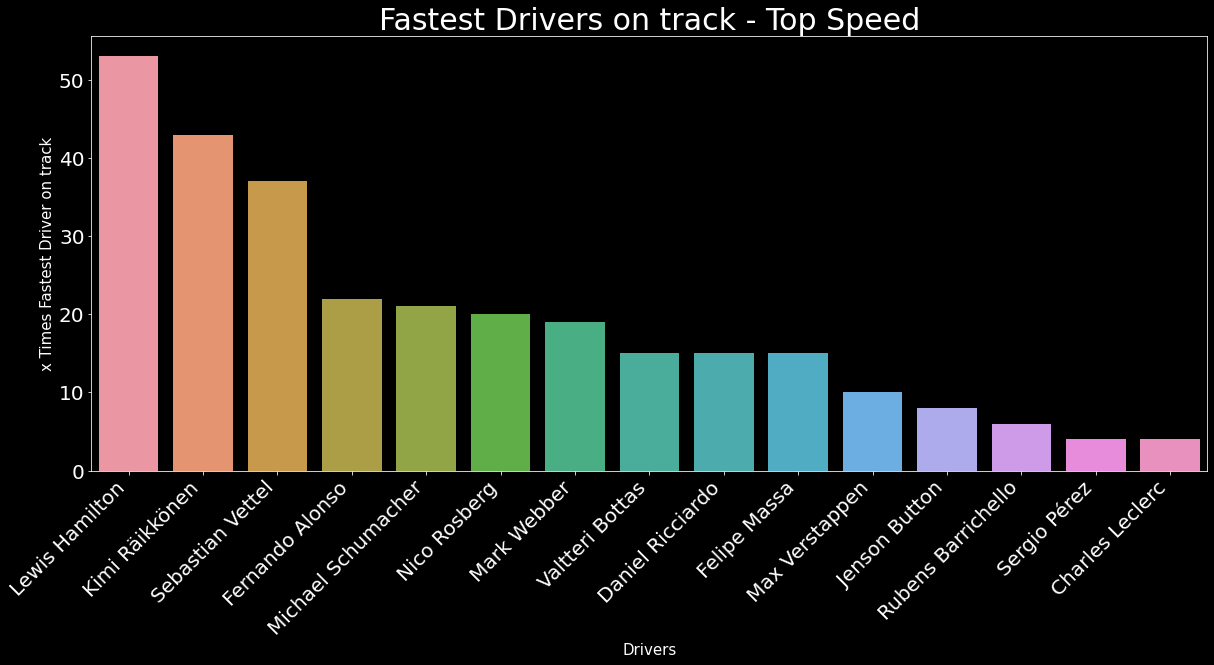

In [85]:
f_laps_speed = data.copy()
f_laps_speed = f_laps_speed[['raceId', 'year', 'fullName', 'fastestLapSpeed']].sort_values(['year', 'raceId'])
f_laps_speed = f_laps_speed[f_laps_speed['fastestLapSpeed'] != 0]
f_laps_speed = f_laps_speed.drop(['year'], axis = 1)

y = range(1, data.raceId.max()+1)
counts_speed = pd.DataFrame()
for x in y:
    counts_speed = counts_speed.append(f_laps_speed.loc[f_laps_speed['raceId'] == x].sort_values(['fastestLapSpeed'], ascending = False)[:1])

counts_speed = counts_speed.groupby('fullName').count().sort_values(['fastestLapSpeed'], ascending = False)[:15]
counts_speed
fig, axs = plt.subplots(figsize = (20, 8))
axs.tick_params(axis = "x", labelsize = 20)
axs.tick_params(axis = "y", labelsize = 20)

sns.barplot(list(counts_speed.index), counts_speed['fastestLapSpeed'])
axs.set_facecolor('k')
axs.patch.set_alpha(0.9)
plt.xticks(rotation = 45, ha = 'right')
plt.title("Fastest Drivers on track - Top Speed", fontsize = 30)
plt.ylabel('x Times Fastest Driver on track', fontsize = 15)
plt.xlabel('Drivers', fontsize = 15)
plt.show()

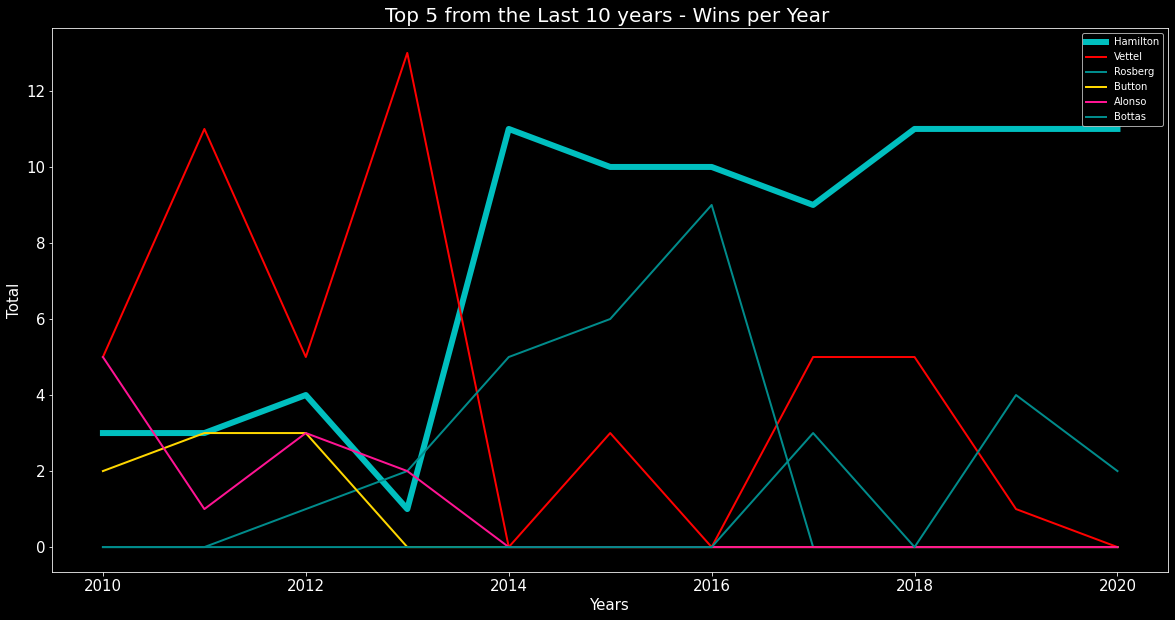

In [86]:
def wins_per_year(driverRef, year):
    try:
        return topTenYears.loc[(topTenYears['driverRef'] == driverRef) & (topTenYears['positionOrder'] == 1) & 
                               (topTenYears['year'] == year)].groupby('driverId')['raceId'].count().values[0]
    except:
        return 0

topTenYears = data.copy()
hamWinsPerYear = []
vetWinsPerYear = []
rosWinsPerYear = []
butWinsPerYear = []
aloWinsPerYear = []
botWinsPerYear = []

x = (2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020)

for year in x:
    hamWinsPerYear.append(wins_per_year('hamilton',year))
    vetWinsPerYear.append(wins_per_year('vettel',year))
    rosWinsPerYear.append(wins_per_year('rosberg',year))
    butWinsPerYear.append(wins_per_year('button',year))
    aloWinsPerYear.append(wins_per_year('alonso',year))
    botWinsPerYear.append(wins_per_year('bottas',year))

fig, axs = plt.subplots(figsize = (20, 10))
axs.tick_params(axis = "x", labelsize = 15)
axs.tick_params(axis = "y", labelsize = 15)

line1, = axs.plot(x, hamWinsPerYear, label = 'Hamilton', color='c', linewidth = 6,)
line2, = axs.plot(x, vetWinsPerYear, label = 'Vettel', color = 'r', linewidth = 2)
line3, = axs.plot(x, rosWinsPerYear, label = 'Rosberg', color = 'darkcyan', linewidth = 2)
line4, = axs.plot(x, butWinsPerYear, label = 'Button', color = 'gold', linewidth = 2)
line5, = axs.plot(x, aloWinsPerYear, label = 'Alonso', color = 'deeppink', linewidth = 2)
line5, = axs.plot(x, botWinsPerYear, label = 'Bottas', color = 'darkcyan', linewidth = 2)
plt.title("Top 5 from the Last 10 years - Wins per Year ", fontsize = 20)
plt.ylabel('Total', fontsize = 15)
plt.xlabel('Years', fontsize = 15)
axs.legend()
plt.show()

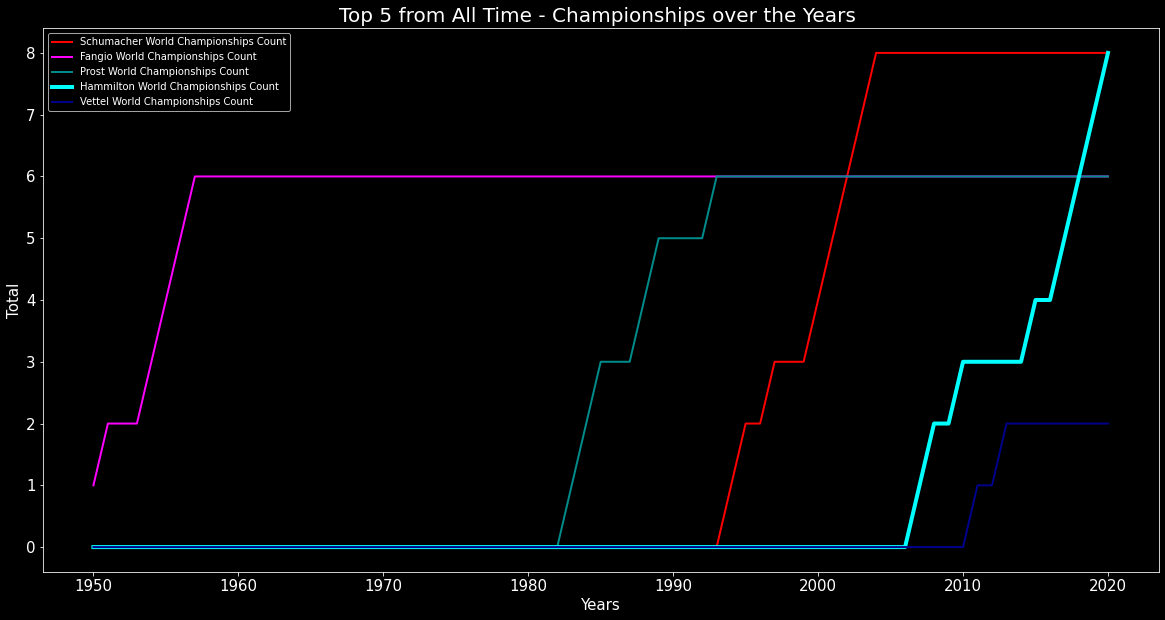

In [87]:
def championsInYears(years, driverRef):
    total = []
    t = 0
    for year in years:
        winner = topTenYears.loc[topTenYears['year'] == year].groupby('driverRef')['driverPoints'].sum().sort_values(ascending = False).index[0]
        if winner == driverRef:
            t = t + 1
        total.append(t)
    return total

schumiCP = championsInYears(np.sort(topTenYears['year'].unique()), 'michael_schumacher')
fangioCP = championsInYears(np.sort(topTenYears['year'].unique()), 'fangio')
prostCP = championsInYears(np.sort(topTenYears['year'].unique()), 'prost')
hamiltonCP = championsInYears(np.sort(topTenYears['year'].unique()), 'hamilton')
vettelCP = championsInYears(np.sort(topTenYears['year'].unique()), 'vettel')

x = range(1950, 2021)

fig, axs = plt.subplots(figsize = (20, 10))
axs.tick_params(axis = "x", labelsize = 15)
axs.tick_params(axis = "y", labelsize = 15)

line1, = axs.plot(x, schumiCP, label = 'Schumacher World Championships Count', color = 'r', linewidth = 2)
line2, = axs.plot(x, fangioCP, label = 'Fangio World Championships Count', color = 'magenta', linewidth = 2)
line3, = axs.plot(x, prostCP, label = 'Prost World Championships Count', color ='darkcyan', linewidth = 2)
line4, = axs.plot(x, hamiltonCP, label = 'Hammilton World Championships Count', color = 'aqua', linewidth = 4)
line5, = axs.plot(x, vettelCP, label = 'Vettel World Championships Count', color = 'darkblue', linewidth= 2)
plt.title("Top 5 from All Time - Championships over the Years ", fontsize = 20)
plt.ylabel('Total', fontsize = 15)
plt.xlabel('Years', fontsize = 15)
axs.legend()
plt.show()

#### Hamilton Rosberg Rivalry

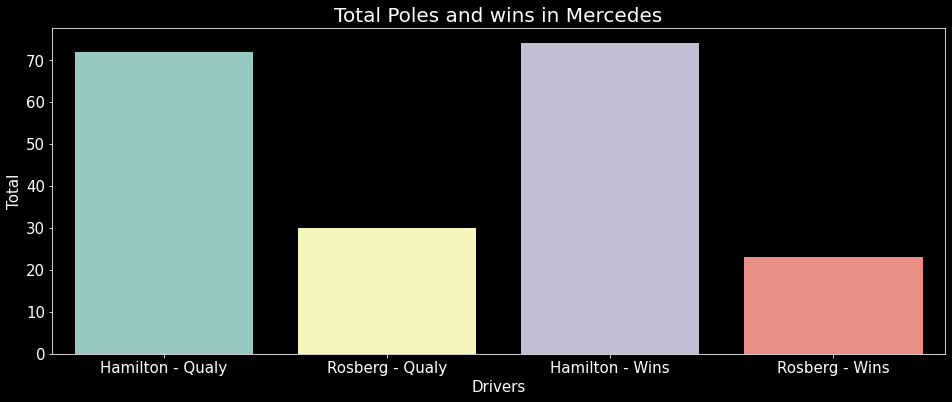

No handles with labels found to put in legend.


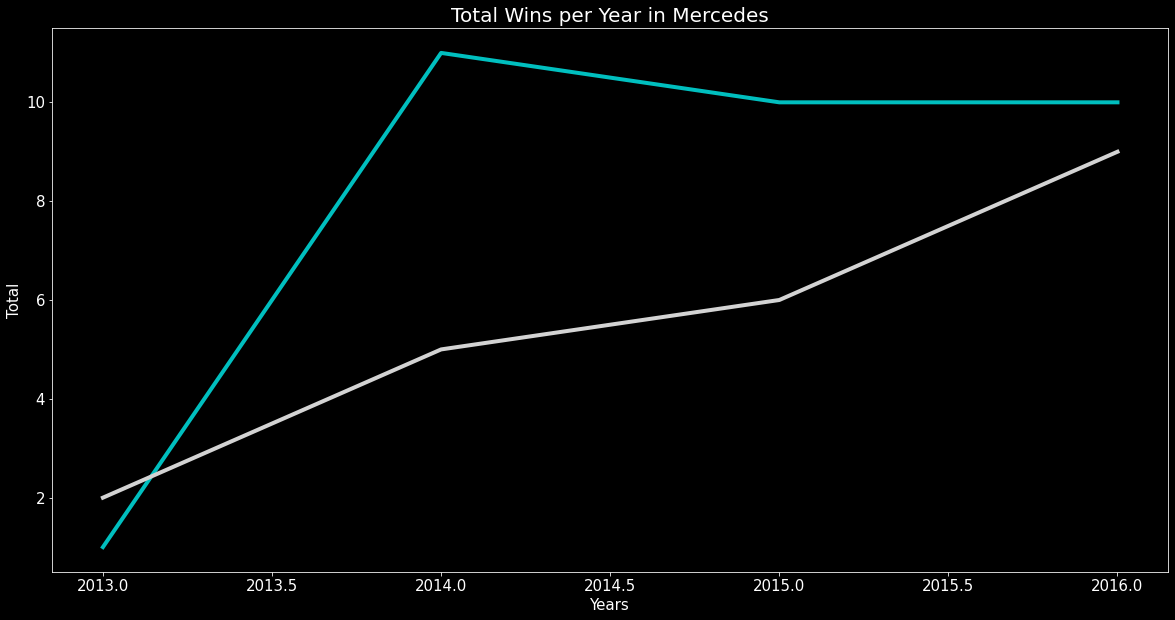

In [88]:
mercedesId = constructors.loc[(constructors['constructorRef'] == 'mercedes')]['constructorId'].values[0]
hamQtdQualy = len(qualifying.loc[(qualifying['driverId'] == 1) & (qualifying['position'] == 1) & (qualifying['constructorId'] == mercedesId)])
rosQtdQualy = len(qualifying.loc[(qualifying['driverId'] == 3 ) & (qualifying['position'] == 1) & (qualifying['constructorId'] == mercedesId)])
hamQtdRaces = len(results.loc[(results['positionOrder'] == 1) & (results['driverId'] == 1) & (results['constructorId'] == 131)])
rosQtdRaces = len(results.loc[(results['positionOrder'] == 1) & (results['driverId'] == 3) & (results['constructorId'] == 131)])
hamWinsPerYear = data.loc[(data['driverId']==1) & (data['constructorId'] == 131) &
                          (data['positionOrder'] == 1) & (data['year'] < 2017)].groupby('year')['driverId'].count()
rosWinsPerYear = data.loc[(data['driverId']==3) & (data['constructorId'] == 131) &
                          (data['positionOrder'] == 1) & (data['year'] > 2012)].groupby('year')['driverId'].count()

fig, axs = plt.subplots(figsize = (16, 6))
axs.tick_params(axis = "x", labelsize = 15)
axs.tick_params(axis = "y", labelsize = 15)

sns.barplot(['Hamilton - Qualy', 'Rosberg - Qualy', 'Hamilton - Wins', 'Rosberg - Wins'], [hamQtdQualy, rosQtdQualy, hamQtdRaces, rosQtdRaces])
axs.set_facecolor('k')
plt.title("Total Poles and wins in Mercedes", fontsize = 20)
plt.ylabel('Total', fontsize = 15)
plt.xlabel('Drivers', fontsize = 15)
plt.show()

x = list(hamWinsPerYear.index)
y = hamWinsPerYear
f,ax = plt.subplots(figsize = (20, 10))
ax.tick_params(axis="x", labelsize = 15)
ax.tick_params(axis="y", labelsize = 15)

ax.set_facecolor('k')
line1, = ax.plot(x, hamWinsPerYear.values, label = 'Hamilton Wins', color = 'c', linewidth = 4)
line2, = ax.plot(x, rosWinsPerYear.values, label = 'Rosberg Wins' ,linewidth = 4, color = 'lightgray')
plt.title("Total Wins per Year in Mercedes", fontsize = 20)
plt.ylabel('Total', fontsize = 15)
plt.xlabel('Years', fontsize = 15)
axs.legend()
plt.show()

#### Iconic races for Hamilton

Suzuka GP 2015 

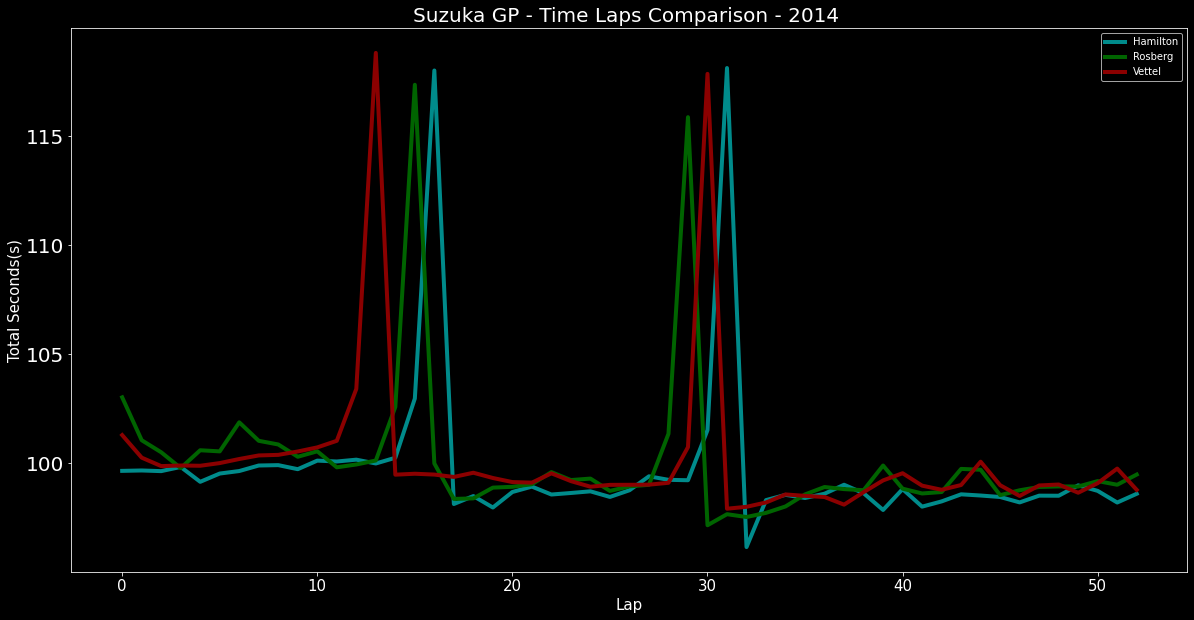

In [89]:
timeHamilton = lap_times.loc[((lap_times['driverId'] == 1) & (lap_times['raceId'] == 940))]['time'].iloc[:].values
timeRos = lap_times.loc[(lap_times['driverId'] == 3) & (lap_times['raceId'] == 940)]['time'].iloc[:].values
timeVet = lap_times.loc[(lap_times['driverId'] == 20) & (lap_times['raceId'] == 940)]['time'].iloc[:].values

x = range(0, 53)
fig, axs = plt.subplots(figsize = (20, 10))
axs.tick_params(axis = "x", labelsize = 15)
axs.tick_params(axis = "y", labelsize = 20)

axs.set_facecolor('k')
axs.patch.set_alpha(0.9)
line1, = axs.plot(x, timeHamilton, label= 'Hamilton', color = 'darkcyan', linewidth = 4)
line2, = axs.plot(x, timeRos, label = 'Rosberg', color = 'darkgreen' , linewidth = 4)
line2, = axs.plot(x, timeVet, label = 'Vettel', color = 'darkred' , linewidth = 4)
plt.title("Suzuka GP - Time Laps Comparison - 2014 ", fontsize = 20)
plt.ylabel('Total Seconds(s)', fontsize = 15)
plt.xlabel('Lap', fontsize = 15)
axs.legend()
plt.show()

Monza GP 2011

Biggest battle between Hamilton and the 7 time world champ Schumacher

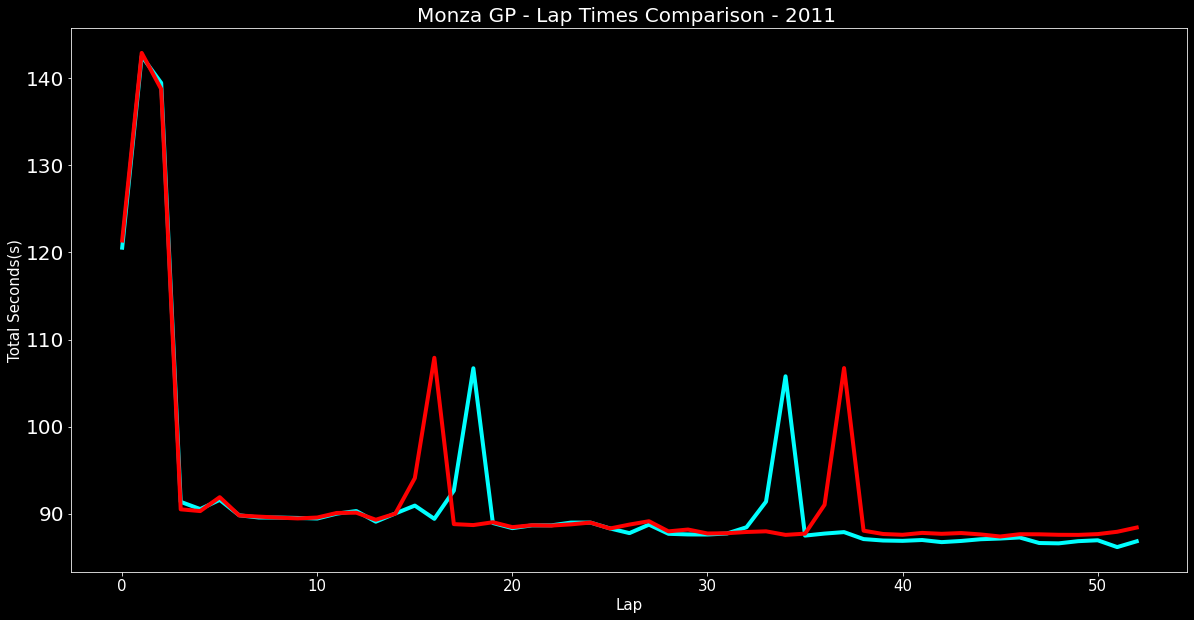

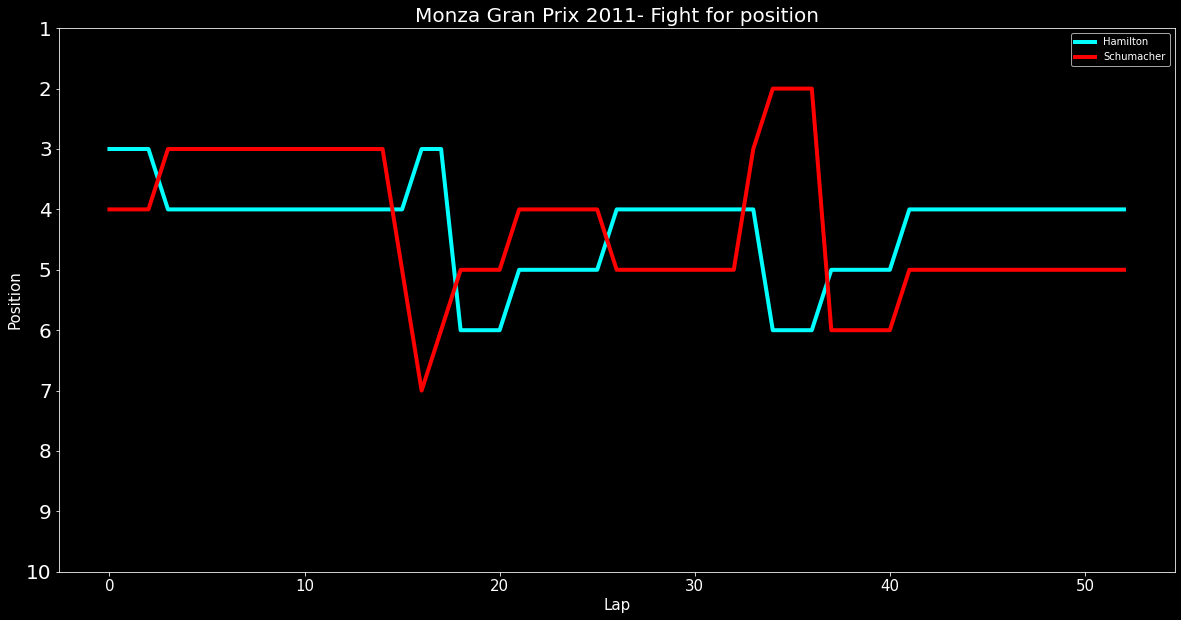

In [90]:
timeHamilton = lap_times.loc[((lap_times['driverId'] == 1) & (lap_times['raceId'] == 853))]['time'].iloc[:].values
timeSchumi = lap_times.loc[(lap_times['driverId'] == 30) & (lap_times['raceId'] == 853)]['time'].iloc[:].values
x = range(0, 53)
fig, axs = plt.subplots(figsize = (20, 10))
axs.tick_params(axis = "x", labelsize = 15)
axs.tick_params(axis = "y", labelsize = 20)

axs.set_facecolor('k')
axs.patch.set_alpha(0.9)
line1, = axs.plot(x, timeHamilton, label = 'Hamilton', color = 'cyan', linewidth = 4)
line2, = axs.plot(x, timeSchumi, label = 'Schumacher' , color = 'red', linewidth = 4)
plt.title("Monza GP - Lap Times Comparison - 2011 ", fontsize = 20)
plt.ylabel('Total Seconds(s)', fontsize = 15)
plt.xlabel('Lap', fontsize = 15)
ax.legend()
plt.show()

positionsHamilton = lap_times.loc[((lap_times['driverId'] == 1) & (lap_times['raceId'] == 853))]['position'].iloc[:].values
positionsSchumi = lap_times.loc[(lap_times['driverId'] == 30) & (lap_times['raceId'] == 853)]['position'].iloc[:].values

x = range(0, 53)
fig, axs = plt.subplots(figsize = (20, 10))
axs.tick_params(axis = "x", labelsize = 15)
axs.tick_params(axis = "y", labelsize = 20)

axs.set_facecolor('k')
axs.patch.set_alpha(0.9)
line1, = axs.plot(x, positionsHamilton, label = 'Hamilton', color = 'cyan', linewidth = 4,)
line2, = axs.plot(x, positionsSchumi, label = 'Schumacher', color = 'red' , linewidth = 4,)
plt.title("Monza Gran Prix 2011- Fight for position", fontsize = 20)
plt.ylabel('Position', fontsize = 15)
plt.xlabel('Lap', fontsize = 15)
axs.legend()
plt.ylim(10, 1)
plt.show()

British GP - 2020

Hamilton's last lap = Lightning McQueen

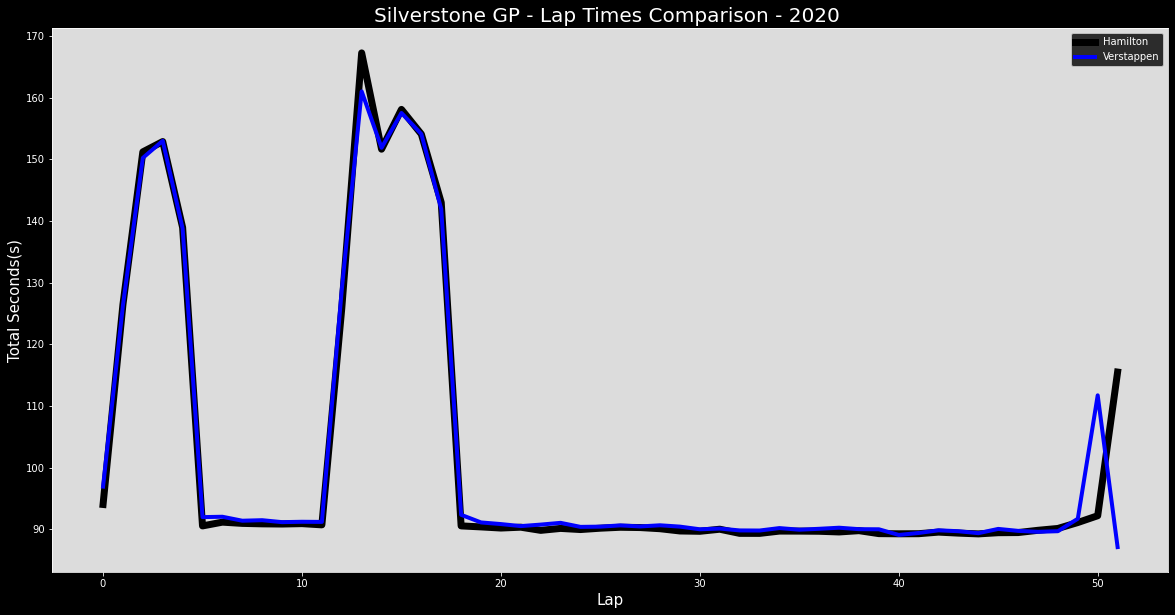

In [91]:
timeHamilton = lap_times.loc[((lap_times['driverId'] == 1) & (lap_times['raceId'] == 1034))]['time'].iloc[:].values
timeVerst = lap_times.loc[(lap_times['driverId'] == 830) & (lap_times['raceId'] == 1034)]['time'].iloc[:].values
x = range(0, 52)
fig, axs = plt.subplots(figsize = (20, 10))
ax.tick_params(axis = "x", labelsize = 15)
ax.tick_params(axis = "y", labelsize = 20)

axs.set_facecolor('whitesmoke')
axs.patch.set_alpha(0.9)
line1, = axs.plot(x, timeHamilton, label = 'Hamilton', color = 'k', linewidth = 7)
line2, = axs.plot(x, timeVerst, label = 'Verstappen', color = 'blue', linewidth = 4)
plt.title("Silverstone GP - Lap Times Comparison - 2020 ", fontsize = 20)
plt.ylabel('Total Seconds(s)', fontsize = 15)
plt.xlabel('Lap', fontsize = 15)
axs.legend()
plt.show()

Turkish GP - 2020

Hamiltons's 7th Title winning race

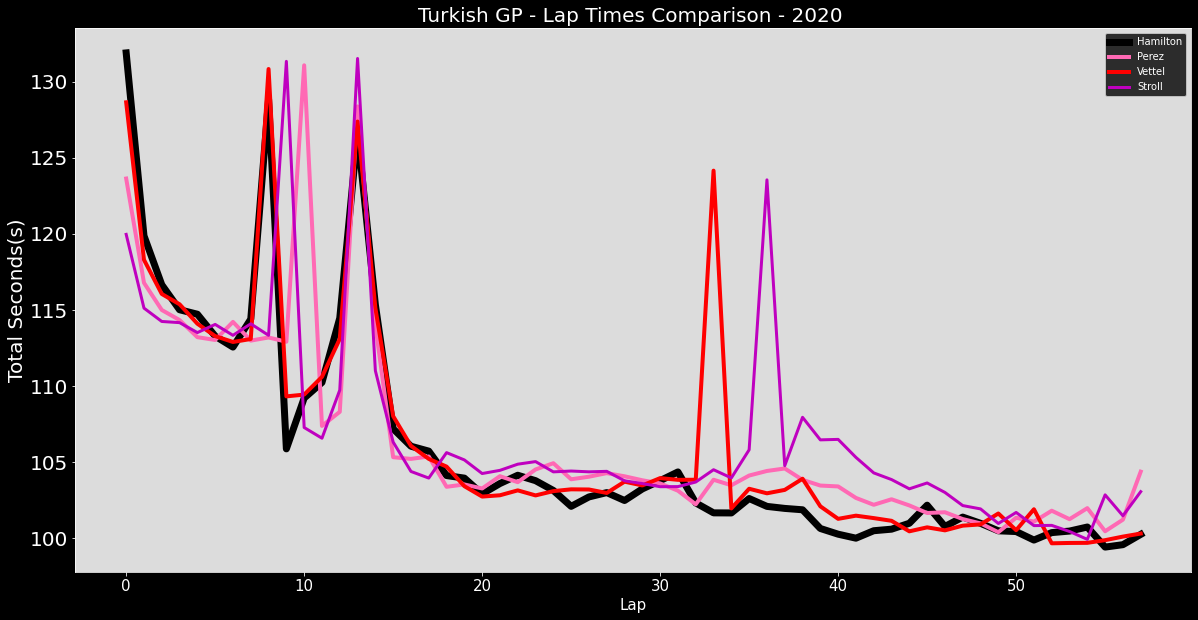

In [92]:
timeHamilton = lap_times.loc[((lap_times['driverId'] == 1) & (lap_times['raceId'] == 1044))]['time'].iloc[:].values
timePerez = lap_times.loc[(lap_times['driverId'] == 815) & (lap_times['raceId'] == 1044)]['time'].iloc[:].values
timeVet = lap_times.loc[(lap_times['driverId'] == 20) & (lap_times['raceId'] == 1044)]['time'].iloc[:].values

timeStroll = lap_times.loc[(lap_times['driverId'] == 840) & (lap_times['raceId'] == 1044)]['time'].iloc[:].values


x = range(0, 58)
fig, axs = plt.subplots(figsize = (20, 10))
axs.tick_params(axis = "x", labelsize = 15)
axs.tick_params(axis = "y", labelsize = 20)

axs.set_facecolor('whitesmoke')
axs.patch.set_alpha(0.9)
line1, = axs.plot(x, timeHamilton, label = 'Hamilton', color = 'k', linewidth = 7)
line2, = axs.plot(x, timePerez, label = 'Perez' , color = 'hotpink', linewidth = 4)
line3, = axs.plot(x, timeVet, label = 'Vettel' , color = 'Red', linewidth = 4)
line4, = axs.plot(x, timeStroll, label = 'Stroll' , color = 'm', linewidth = 3)

plt.title("Turkish GP - Lap Times Comparison - 2020 ", fontsize = 20)
plt.ylabel('Total Seconds(s)', fontsize = 20)
plt.xlabel('Lap', fontsize = 15)
axs.legend()
plt.show()

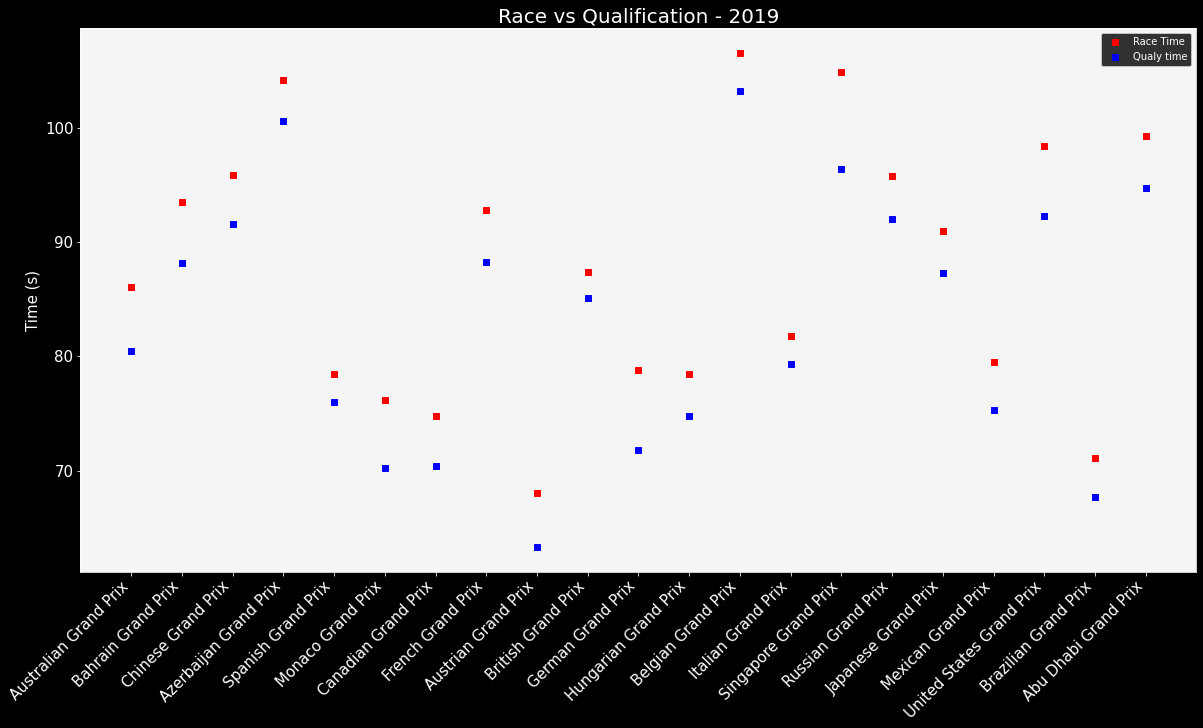

In [93]:
racesQualysHam = data_10.loc[(data_10['driverRef'] == 'hamilton') & (data_10['year'] == 2019) & (data_10['q3'] != 0)]

qualTimes = racesQualysHam['q3'].values
raceTimes = racesQualysHam['fastestLapTime'].values
x = racesQualysHam.GrandPrix.values

fig, axs = plt.subplots(figsize = (20, 10))
axs.tick_params(axis = "x", labelsize = 15)
axs.tick_params(axis = "y", labelsize = 15)

axs.set_facecolor('whitesmoke')
line1, = axs.plot(x, raceTimes, 'bs', c = 'red',label = "Race Time")
line2, = axs.plot(x, qualTimes,'bs', c = 'blue', label = "Qualy time")
plt.title("Race vs Qualification - 2019", fontsize = 20)
plt.ylabel('Time (s)', fontsize = 15)
plt.xticks(rotation = 45, ha = 'right')
axs.legend()
plt.show()

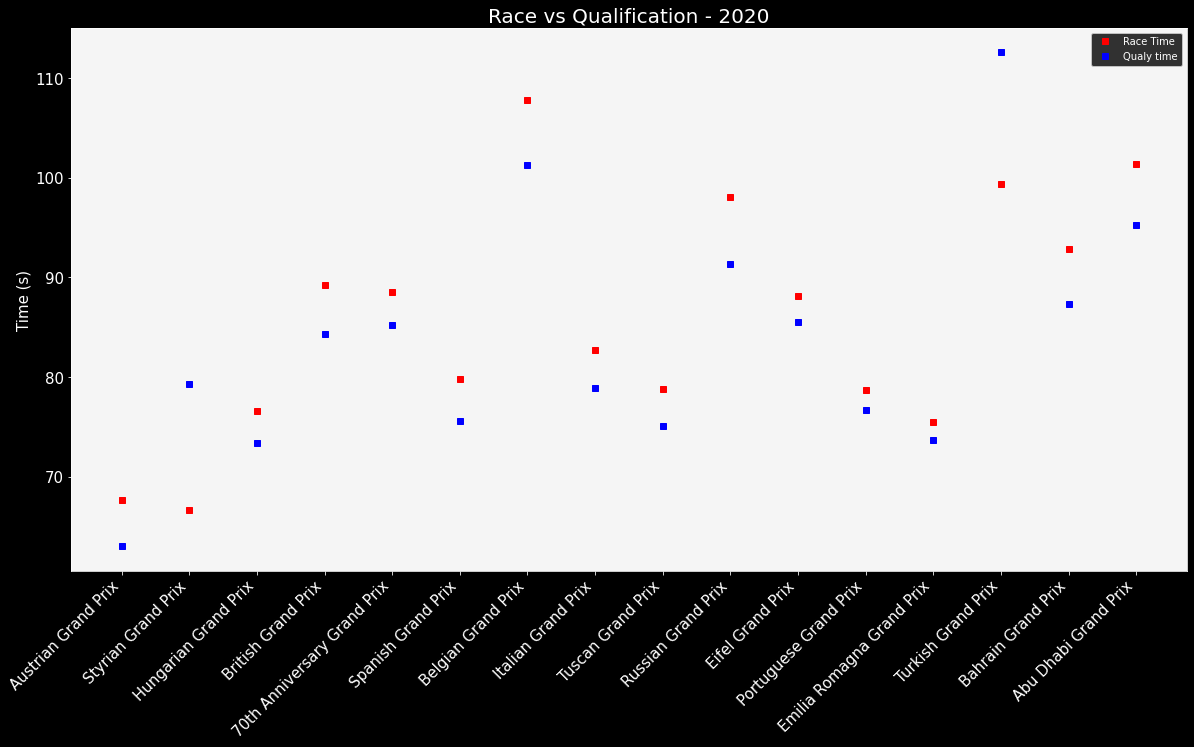

In [94]:
racesQualysHam = data_10.loc[(data_10['driverRef'] == 'hamilton') & (data_10['year'] == 2020) & (data_10['q3'] != 0)]

qualTimes = racesQualysHam['q3'].values
raceTimes = racesQualysHam['fastestLapTime'].values
x = racesQualysHam.GrandPrix.values

fig, axs = plt.subplots(figsize = (20, 10))
axs.tick_params(axis = "x", labelsize = 15)
axs.tick_params(axis = "y", labelsize = 15)

axs.set_facecolor('whitesmoke')
line1, = axs.plot(x, raceTimes, 'bs', c = 'red',label = "Race Time")
line2, = axs.plot(x, qualTimes,'bs', c = 'blue', label = "Qualy time")
plt.title("Race vs Qualification - 2020", fontsize = 20)
plt.ylabel('Time (s)', fontsize = 15)
plt.xticks(rotation = 45, ha = 'right')
axs.legend()
plt.show()

In [95]:
winsHam = data.loc[(data['driverRef']=='hamilton')]['grid'].value_counts()

trace = go.Pie(labels = winsHam.index, values = winsHam.values, hole = 0.6,textinfo = "none")
layout = go.Layout(title = 'Hamilton - Percentage of entered races vs race wins', paper_bgcolor = 'gainsboro')
fig = go.Figure(data = [trace], layout = layout)
fig.update_layout(margin = dict(l = 60, r = 60, t = 50, b = 50))
iplot(fig, filename = "plotting-library")

winsSenna = data.loc[(data['driverRef']=='senna')]['grid'].value_counts()

trace = go.Pie(labels = winsSenna.index, values = winsSenna.values, hole = 0.6,textinfo = "none")
layout = go.Layout(title = 'Senna - Percentage of entered races vs race wins', paper_bgcolor = 'gainsboro')
fig = go.Figure(data = [trace], layout = layout)
fig.update_layout(margin = dict(l = 60, r = 60, t = 50, b = 50))
iplot(fig, filename = "plotting-library")

winsSchumi = data.loc[(data['driverRef']=='michael_schumacher')]['grid'].value_counts()

trace = go.Pie(labels = winsSchumi.index, values = winsSchumi.values, hole = 0.6,textinfo = "none")
layout = go.Layout(title = 'Schumacher - Percentage of entered races vs race wins', paper_bgcolor = 'gainsboro')
fig = go.Figure(data = [trace], layout = layout)
fig.update_layout(margin = dict(l = 60, r = 60, t = 50, b = 50))
iplot(fig, filename = "plotting-library")

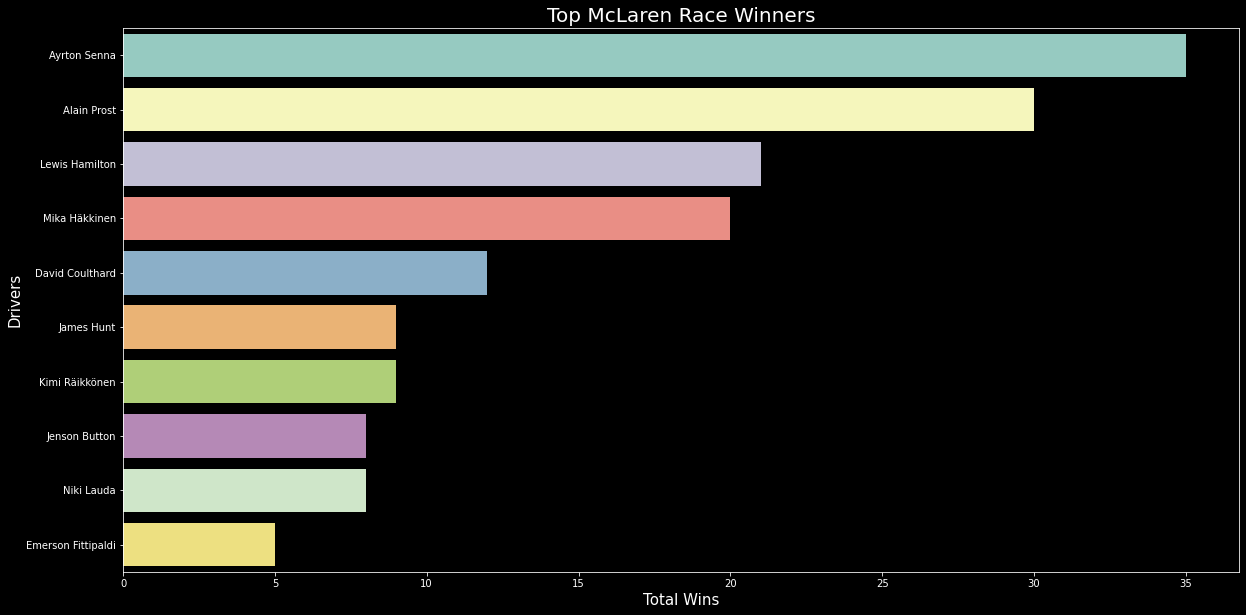

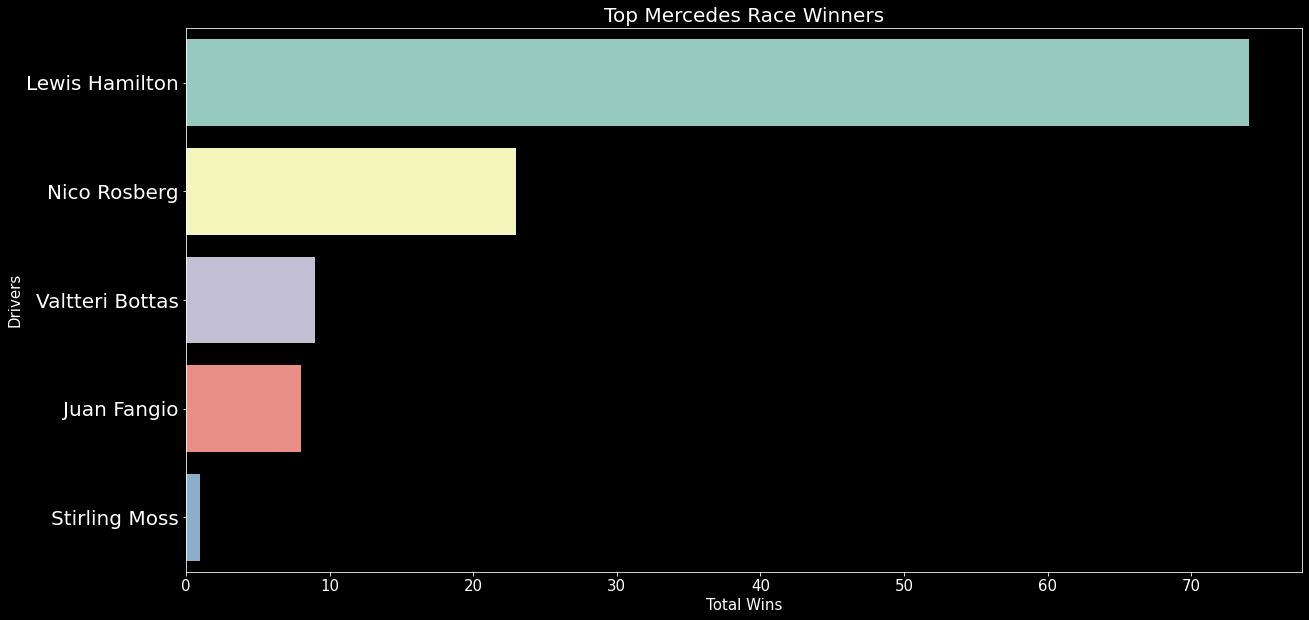

In [96]:
mclarensRacers = data.loc[(data['constructorId'] == 1) &
                                 (data['positionOrder'] == 1)].groupby('fullName')['raceId'].count().sort_values(ascending = False)[:10]

mercedesRacers = data.loc[(data['constructorId'] == 131) &
                                 (data['positionOrder'] == 1)].groupby('fullName')['raceId'].count().sort_values(ascending = False)[:10]

fig, axs = plt.subplots(figsize = (20, 10))
ax.tick_params(axis = "x", labelsize = 15)
ax.tick_params(axis = "y", labelsize = 20)

sns.barplot(list(mclarensRacers.values), list(mclarensRacers.index))
sns.color_palette("hls", 8)
axs.set_facecolor('k')
axs.patch.set_alpha(0.9)
plt.title("Top McLaren Race Winners", fontsize = 20)
plt.ylabel('Drivers', fontsize = 15)
plt.xlabel('Total Wins', fontsize = 15)
plt.show()

fig, axs = plt.subplots(figsize = (20, 10))
axs.tick_params(axis = "x", labelsize = 15)
axs.tick_params(axis = "y", labelsize = 20)

sns.barplot(list(mercedesRacers.values), list(mercedesRacers.index))
sns.color_palette("hls", 8)
axs.set_facecolor('k')
axs.patch.set_alpha(0.9)
plt.title("Top Mercedes Race Winners", fontsize = 20)
plt.ylabel('Drivers', fontsize = 15)
plt.xlabel('Total Wins', fontsize = 15)
plt.show()

# Race Stats Comparison between 2019 and 2020 season

In [97]:
data_19 = data[data['year'] == 2019]
data_20 = data[data['year'] == 2020]

In [98]:
driver_age = data_19.drop_duplicates(subset = ["driverId"])
age_count = driver_age['age'].value_counts()

trace = go.Pie(labels = age_count.index, values = age_count.values, hole = 0.6,textinfo = "none")
layout = go.Layout(title = 'Age distribution across the grid - 2019', paper_bgcolor = 'gainsboro')
fig = go.Figure(data = [trace], layout = layout)
fig.update_layout(margin = dict(l = 60, r = 60, t = 50, b = 50))
iplot(fig, filename = "plotting-library")

In [99]:
driver_age = data_20.drop_duplicates(subset = ["driverId"])
age_count = driver_age['age'].value_counts()

trace = go.Pie(labels = age_count.index, values = age_count.values, hole = 0.6,textinfo = "none")
layout = go.Layout(title = 'Age distribution across the grid - 2020', paper_bgcolor = 'gainsboro')
fig = go.Figure(data = [trace], layout = layout)
fig.update_layout(margin = dict(l = 60, r = 60, t = 50, b = 50))
iplot(fig, filename = "plotting-library")

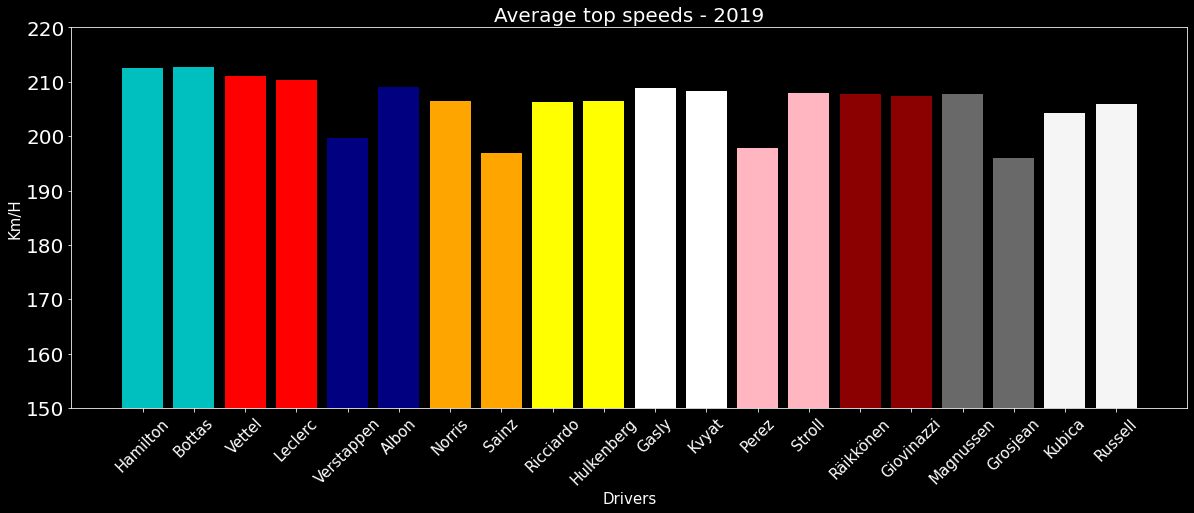

In [100]:
speedHam = (data_19.loc[((data_19['driverId'] == 1))]['fastestLapSpeed'].iloc[:].values.mean())
speedBot = (data_19.loc[((data_19['driverId'] == 822))]['fastestLapSpeed'].iloc[:].values.mean())
speedVet = (data_19.loc[((data_19['driverId'] == 20))]['fastestLapSpeed'].iloc[:].values.mean())
speedLec = (data_19.loc[((data_19['driverId'] == 844))]['fastestLapSpeed'].iloc[:].values.mean())
speedVer = (data_19.loc[((data_19['driverId'] == 830))]['fastestLapSpeed'].iloc[:].values.mean())
speedAlb = (data_19.loc[((data_19['driverId'] == 848))]['fastestLapSpeed'].iloc[:].values.mean())
speedNor = (data_19.loc[((data_19['driverId'] == 846))]['fastestLapSpeed'].iloc[:].values.mean())
speedSai = (data_19.loc[((data_19['driverId'] == 832))]['fastestLapSpeed'].iloc[:].values.mean())
speedRic = (data_19.loc[((data_19['driverId'] == 817))]['fastestLapSpeed'].iloc[:].values.mean())
speedHul = (data_19.loc[((data_19['driverId'] == 807))]['fastestLapSpeed'].iloc[:].values.mean())
speedGas = (data_19.loc[((data_19['driverId'] == 842))]['fastestLapSpeed'].iloc[:].values.mean())
speedKyv = (data_19.loc[((data_19['driverId'] == 826))]['fastestLapSpeed'].iloc[:].values.mean())
speedPerez = (data_19.loc[((data_19['driverId'] == 815))]['fastestLapSpeed'].iloc[:].values.mean())
speedStr = (data_19.loc[((data_19['driverId'] == 840))]['fastestLapSpeed'].iloc[:].values.mean())
speedRai = (data_19.loc[((data_19['driverId'] == 8))]['fastestLapSpeed'].iloc[:].values.mean())
speedGio = (data_19.loc[((data_19['driverId'] == 841))]['fastestLapSpeed'].iloc[:].values.mean())
speedMag = (data_19.loc[((data_19['driverId'] == 825))]['fastestLapSpeed'].iloc[:].values.mean())
speedGro = (data_19.loc[((data_19['driverId'] == 154))]['fastestLapSpeed'].iloc[:].values.mean())
speedKub = (data_19.loc[((data_19['driverId'] == 9))]['fastestLapSpeed'].iloc[:].values.mean())
speedRus = (data_19.loc[((data_19['driverId'] == 847))]['fastestLapSpeed'].iloc[:].values.mean())

fig, axs = plt.subplots(figsize = (20, 7))
axs.tick_params(axis = "x", labelsize = 15)
axs.tick_params(axis = "y", labelsize = 20)
plt.xticks(rotation = 45)

axs.set_facecolor('k')
axs.patch.set_alpha(0.9)
line1, = axs.bar('Hamilton', speedHam, color = 'c')
line2, = axs.bar('Bottas', speedBot, color = 'c')
line3, = axs.bar('Vettel', speedVet, color = 'r')
line4, = axs.bar('Leclerc', speedLec, color = 'r')
line5, = axs.bar('Verstappen', speedVer, color = 'navy')
line6, = axs.bar('Albon', speedAlb, color = 'navy')
line7, = axs.bar('Norris', speedNor, color = 'orange')
line8, = axs.bar('Sainz', speedSai, color = 'orange')
line9, = axs.bar('Ricciardo', speedRic, color = 'yellow')
line10, = axs.bar('Hulkenberg', speedHul, color = 'yellow')
line11, = axs.bar('Gasly', speedGas, color = 'white')
line12, = axs.bar('Kvyat', speedKyv, color = 'white')
line13, = axs.bar('Perez', speedPerez, color = 'lightpink')
line14, = axs.bar('Stroll', speedStr, color = 'lightpink')
line15, = axs.bar('Räikkönen', speedRai, color = 'darkred')
line16, = axs.bar('Giovinazzi', speedGio, color = 'darkred')
line17, = axs.bar('Magnussen', speedMag, color = 'dimgrey')
line18, = axs.bar('Grosjean', speedGro, color = 'dimgrey')
line19, = axs.bar('Kubica', speedKub, color = 'whitesmoke')
line20, = axs.bar('Russell', speedRus, color = 'whitesmoke')

plt.ylim(150, 220)
plt.title("Average top speeds - 2019", fontsize = 20)
plt.ylabel('Km/H', fontsize = 15)
plt.xlabel('Drivers', fontsize = 15)
plt.show()

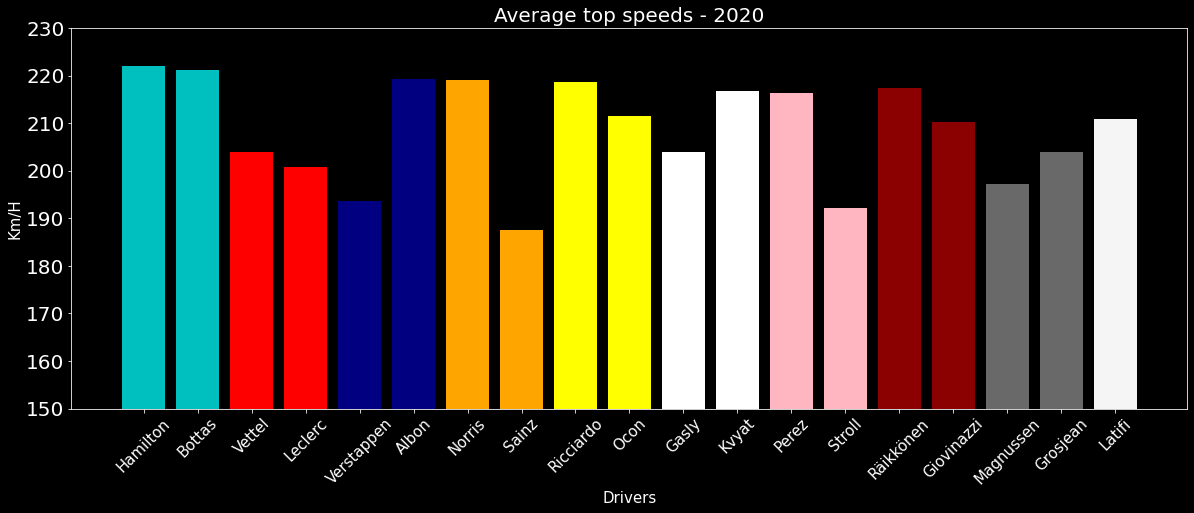

In [101]:
speedHam2 = (data_20.loc[((data_20['driverId'] == 1))]['fastestLapSpeed'].iloc[:].values.mean())
speedBot2 = (data_20.loc[((data_20['driverId'] == 822))]['fastestLapSpeed'].iloc[:].values.mean())
speedVet2 = (data_20.loc[((data_20['driverId'] == 20))]['fastestLapSpeed'].iloc[:].values.mean())
speedLec2 = (data_20.loc[((data_20['driverId'] == 844))]['fastestLapSpeed'].iloc[:].values.mean())
speedVer2 = (data_20.loc[((data_20['driverId'] == 830))]['fastestLapSpeed'].iloc[:].values.mean())
speedAlb2 = (data_20.loc[((data_20['driverId'] == 848))]['fastestLapSpeed'].iloc[:].values.mean())
speedNor2 = (data_20.loc[((data_20['driverId'] == 846))]['fastestLapSpeed'].iloc[:].values.mean())
speedSai2 = (data_20.loc[((data_20['driverId'] == 832))]['fastestLapSpeed'].iloc[:].values.mean())
speedRic2 = (data_20.loc[((data_20['driverId'] == 817))]['fastestLapSpeed'].iloc[:].values.mean())
speedOco = (data_20.loc[((data_20['driverId'] == 839))]['fastestLapSpeed'].iloc[:].values.mean())
speedGas2 = (data_20.loc[((data_20['driverId'] == 842))]['fastestLapSpeed'].iloc[:].values.mean())
speedKyv2 = (data_20.loc[((data_20['driverId'] == 826))]['fastestLapSpeed'].iloc[:].values.mean())
speedPerez2 = (data_20.loc[((data_20['driverId'] == 815))]['fastestLapSpeed'].iloc[:].values.mean())
speedStr2 = (data_20.loc[((data_20['driverId'] == 840))]['fastestLapSpeed'].iloc[:].values.mean())
speedRai2 = (data_20.loc[((data_20['driverId'] == 8))]['fastestLapSpeed'].iloc[:].values.mean())
speedGio2 = (data_20.loc[((data_20['driverId'] == 841))]['fastestLapSpeed'].iloc[:].values.mean())
speedMag2 = (data_20.loc[((data_20['driverId'] == 825))]['fastestLapSpeed'].iloc[:].values.mean())
speedGro2 = (data_20.loc[((data_20['driverId'] == 154))]['fastestLapSpeed'].iloc[:].values.mean())
speedLat = (data_20.loc[((data_20['driverId'] == 849))]['fastestLapSpeed'].iloc[:].values.mean())
speedRus2 = (data_20.loc[((data_20['driverId'] == 847))]['fastestLapSpeed'].iloc[:].values.mean())

fig, axs = plt.subplots(figsize = (20, 7))
axs.tick_params(axis = "x", labelsize = 15)
axs.tick_params(axis = "y", labelsize = 20)
plt.xticks(rotation = 45)

axs.set_facecolor('k')
axs.patch.set_alpha(0.9)
line1, = axs.bar('Hamilton', speedHam2, color = 'c')
line2, = axs.bar('Bottas', speedBot2, color = 'c')
line3, = axs.bar('Vettel', speedVet2, color = 'r')
line4, = axs.bar('Leclerc', speedLec2, color = 'r')
line5, = axs.bar('Verstappen', speedVer2, color = 'navy')
line6, = axs.bar('Albon', speedAlb2, color = 'navy')
line7, = axs.bar('Norris', speedNor2, color = 'orange')
line8, = axs.bar('Sainz', speedSai2, color = 'orange')
line9, = axs.bar('Ricciardo', speedRic2, color = 'yellow')
line10, = axs.bar('Ocon', speedOco, color = 'yellow')
line11, = axs.bar('Gasly', speedGas2, color = 'white')
line12, = axs.bar('Kvyat', speedKyv2, color = 'white')
line13, = axs.bar('Perez', speedPerez2, color = 'lightpink')
line14, = axs.bar('Stroll', speedStr2, color = 'lightpink')
line15, = axs.bar('Räikkönen', speedRai2, color = 'darkred')
line16, = axs.bar('Giovinazzi', speedGio2, color = 'darkred')
line17, = axs.bar('Magnussen', speedMag2, color = 'dimgrey')
line18, = axs.bar('Grosjean', speedGro2, color = 'dimgrey')
line19, = axs.bar('Latifi', speedLat, color = 'whitesmoke')
line20, = ax.bar('Russell', speedRus2, color = 'whitesmoke')

plt.ylim(150, 230)
plt.title("Average top speeds - 2020", fontsize = 20)
plt.ylabel('Km/H', fontsize = 15)
plt.xlabel('Drivers', fontsize = 15)
plt.show()

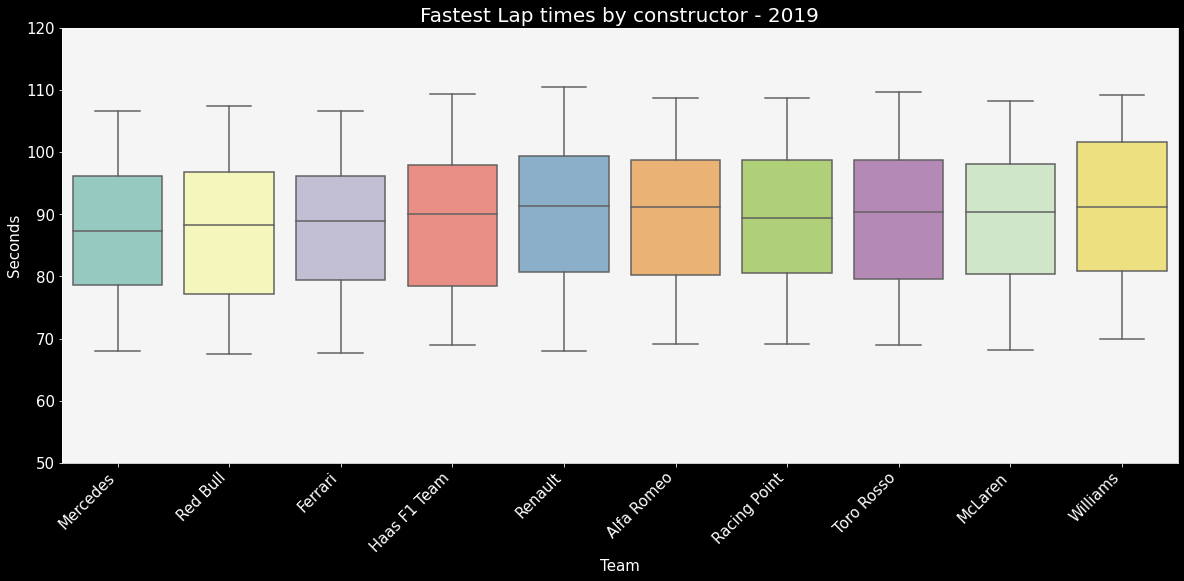

In [102]:
plt.style.use('dark_background')
fig, axs = plt.subplots(figsize = (20, 8))
axs.tick_params(axis = "x", labelsize = 15)
axs.tick_params(axis = "y", labelsize = 15)
axs.set_facecolor('whitesmoke')

sns.boxplot(x = 'constructor', y = 'fastestLapTime', data = data_19)
plt.ylim(50, 120)
plt.title("Fastest Lap times by constructor - 2019",fontsize = 20)
plt.xlabel('Team', fontsize = 15)
plt.ylabel('Seconds', fontsize = 15)
plt.xticks(rotation = 45, ha = 'right')
plt.show()

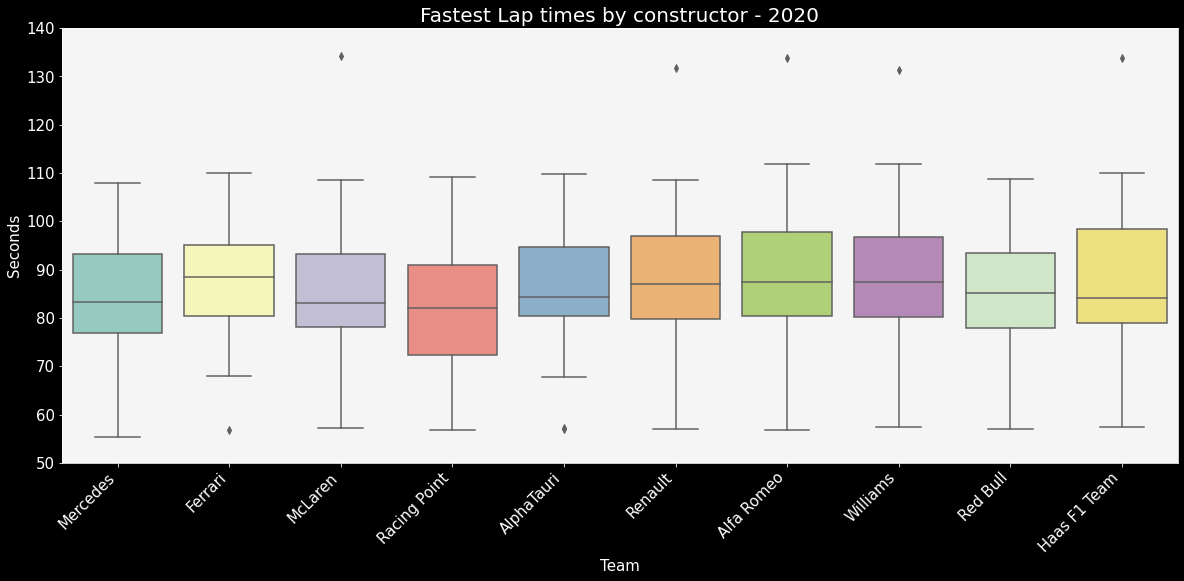

In [103]:
plt.style.use('dark_background')
fig, axs = plt.subplots(figsize = (20, 8))
axs.tick_params(axis = "x", labelsize = 15)
axs.tick_params(axis = "y", labelsize = 15)
axs.set_facecolor('whitesmoke')

sns.boxplot(x = 'constructor', y = 'fastestLapTime', data = data_20)
plt.ylim(50, 140)
plt.title("Fastest Lap times by constructor - 2020", fontsize = 20)
plt.xlabel('Team', fontsize = 15)
plt.ylabel('Seconds', fontsize = 15)
plt.xticks(rotation = 45, ha = 'right')
plt.show()

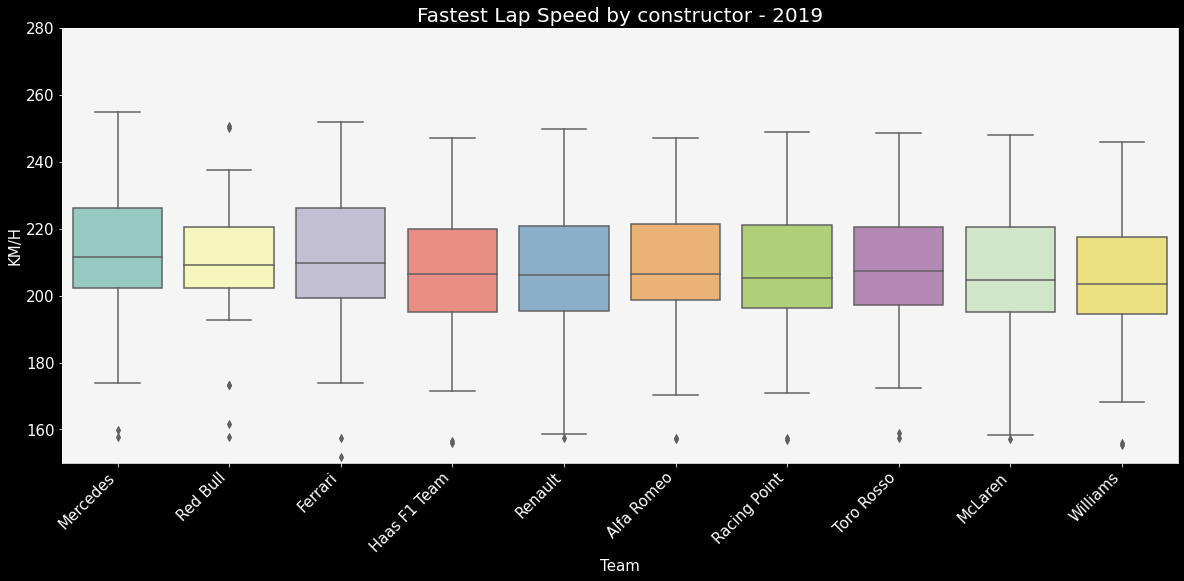

In [104]:
plt.style.use('dark_background')
fig, axs = plt.subplots(figsize = (20, 8))
axs.tick_params(axis = "x", labelsize = 15)
axs.tick_params(axis = "y", labelsize = 15)
axs.set_facecolor('whitesmoke')

sns.boxplot(x = 'constructor', y = 'fastestLapSpeed', data = data_19)
plt.ylim(150, 280)
plt.title("Fastest Lap Speed by constructor - 2019",fontsize = 20)
plt.xlabel('Team', fontsize = 15)
plt.ylabel('KM/H', fontsize = 15)
plt.xticks(rotation = 45, ha = 'right')
plt.show()

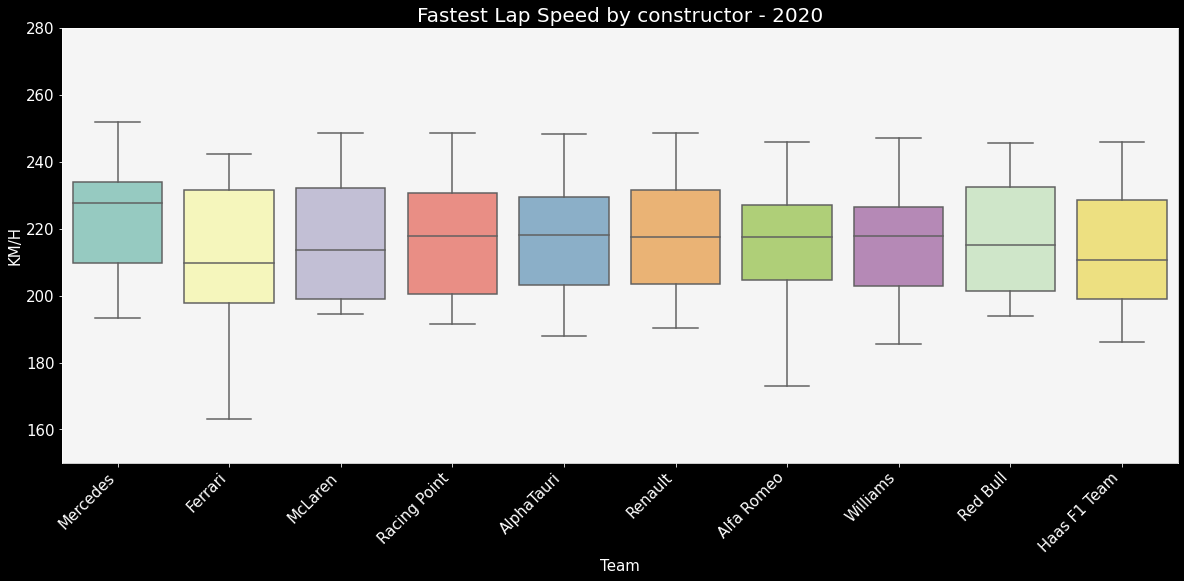

In [105]:
plt.style.use('dark_background')
fig, axs = plt.subplots(figsize = (20, 8))
axs.tick_params(axis = "x", labelsize = 15)
axs.tick_params(axis = "y", labelsize = 15)
axs.set_facecolor('whitesmoke')

sns.boxplot(x = 'constructor', y = 'fastestLapSpeed', data = data_20)
plt.ylim(150, 280)
plt.title("Fastest Lap Speed by constructor - 2020", fontsize = 20)
plt.xlabel('Team', fontsize = 15)
plt.ylabel('KM/H', fontsize = 15)
plt.xticks(rotation = 45, ha = 'right')
plt.show()

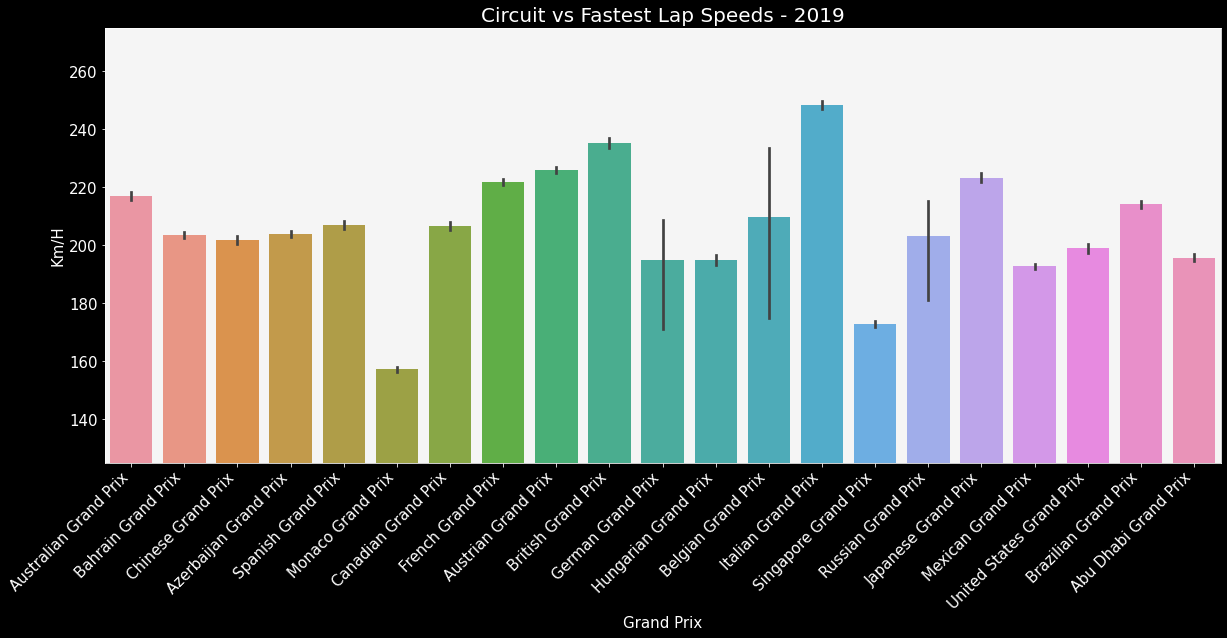

In [106]:
plt.style.use('dark_background')
fig, axs = plt.subplots(figsize = (20, 8))
axs.tick_params(axis = "x", labelsize = 15)
axs.tick_params(axis = "y", labelsize = 15)
axs.set_facecolor('whitesmoke')

sns.barplot(x = 'GrandPrix', y = 'fastestLapSpeed', data = data_19)
plt.ylim(125, 275)
plt.title("Circuit vs Fastest Lap Speeds - 2019", fontsize = 20)
plt.xlabel('Grand Prix', fontsize = 15)
plt.ylabel('Km/H', fontsize = 15)
plt.xticks(rotation = 45, ha = 'right')
plt.show()

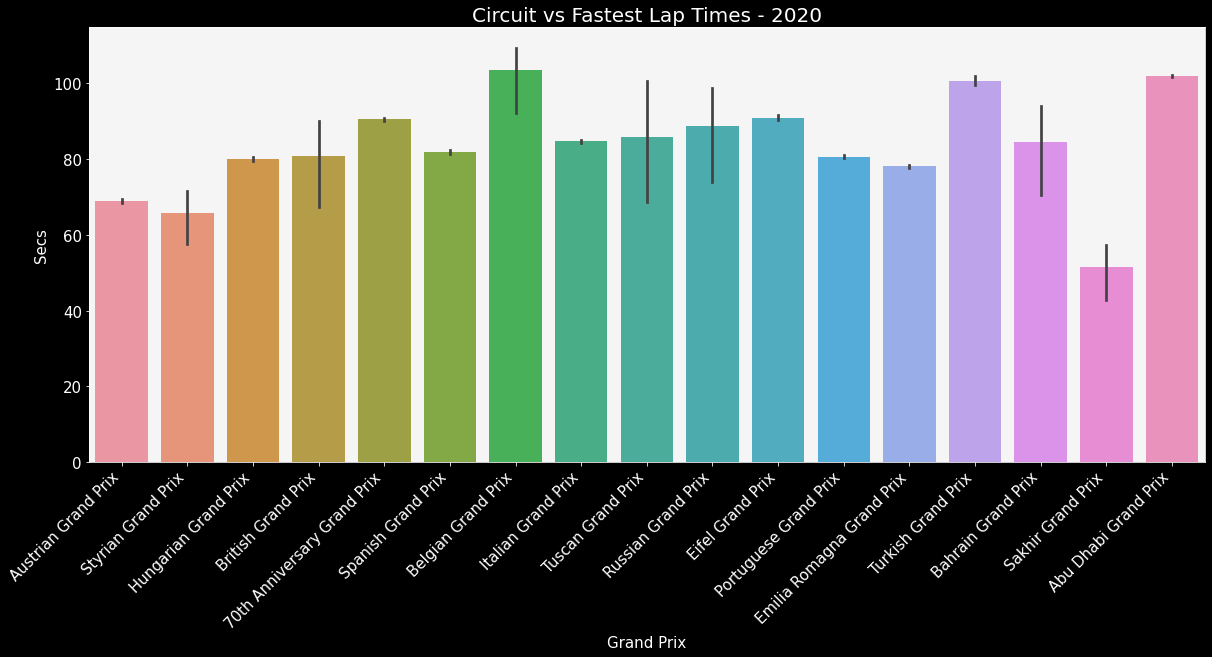

In [107]:
plt.style.use('dark_background')
fig, axs = plt.subplots(figsize=(20, 8))
axs.tick_params(axis = "x", labelsize = 15)
axs.tick_params(axis = "y", labelsize = 15)
axs.set_facecolor('whitesmoke')

sns.barplot(x = 'GrandPrix', y = 'fastestLapTime', data = data_20)
plt.title("Circuit vs Fastest Lap Times - 2020",fontsize = 20)
plt.xlabel('Grand Prix', fontsize = 15)
plt.ylabel('Secs', fontsize = 15)
plt.xticks(rotation = 45, ha = 'right')
plt.show()

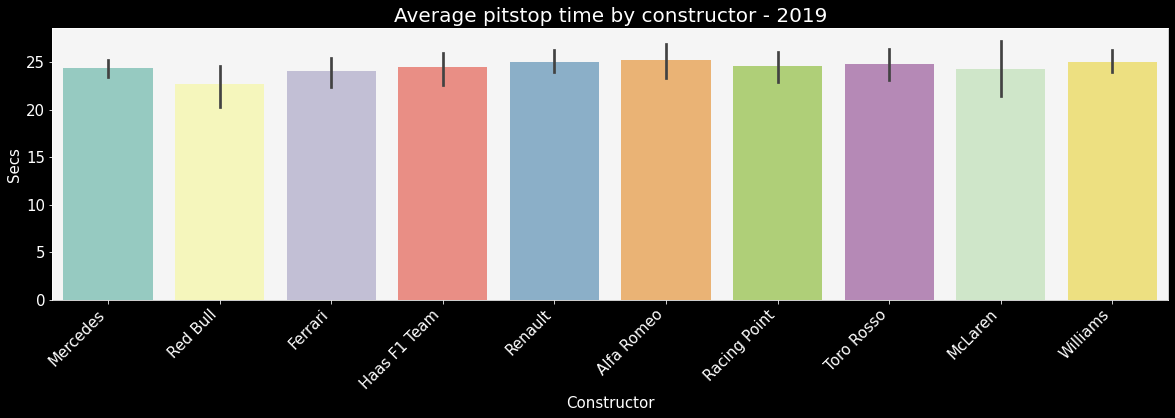

In [108]:
plt.style.use('dark_background')
fig, axs = plt.subplots(figsize=(20, 5))
axs.tick_params(axis = "x", labelsize = 15)
axs.tick_params(axis = "y", labelsize = 15)
axs.set_facecolor('whitesmoke')

sns.barplot(x = 'constructor', y = 'pitStopDuration', data = data_19)
plt.title("Average pitstop time by constructor - 2019",fontsize = 20)
plt.xlabel('Constructor', fontsize = 15)
plt.ylabel('Secs', fontsize = 15)
plt.xticks(rotation = 45, ha = 'right')
plt.show()

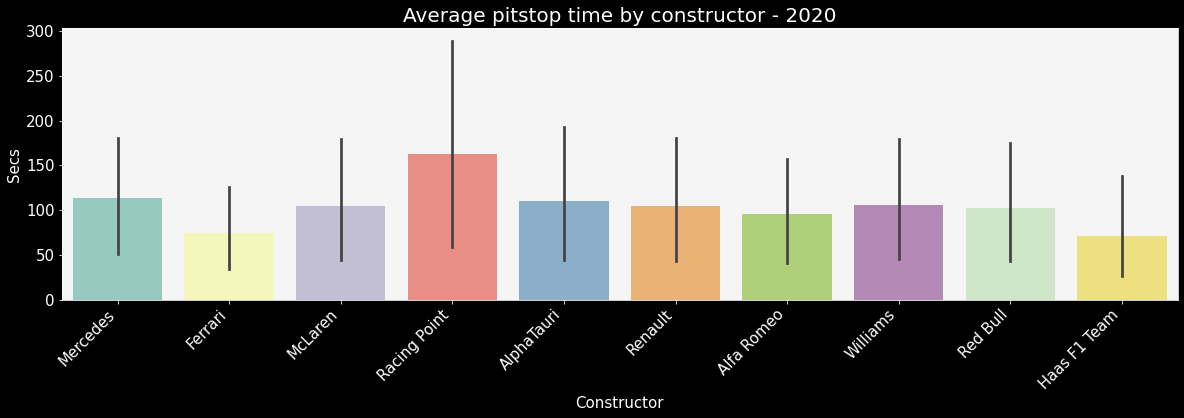

In [109]:
plt.style.use('dark_background')
fig, axs = plt.subplots(figsize=(20, 5))
axs.tick_params(axis = "x", labelsize = 15)
axs.tick_params(axis = "y", labelsize = 15)
axs.set_facecolor('whitesmoke')

sns.barplot(x = 'constructor', y = 'pitStopDuration', data = data_20)
plt.title("Average pitstop time by constructor - 2020",fontsize = 20)
plt.xlabel('Constructor', fontsize = 15)
plt.ylabel('Secs', fontsize = 15)
plt.xticks(rotation = 45, ha = 'right')
plt.show()

2020 season saw a lot of red flags which caused the average pit stop time to go higher.

# Model Building

In [110]:
data_backup = data.copy()

data_backup.to_csv('final_data.csv', index = False)
# data = pd.read_csv('final_data.csv')

<AxesSubplot:>

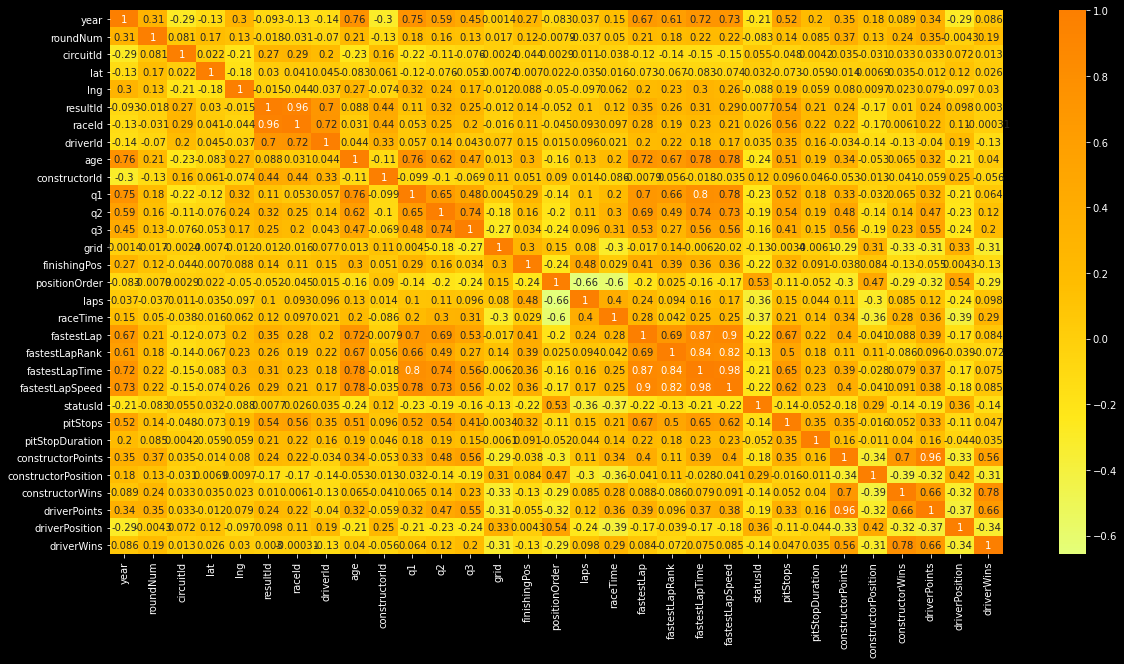

In [111]:
corrplot = data.corr()
plt.style.use("dark_background")
plt.figure(figsize = (20, 10))
sns.heatmap(corrplot, cmap = "Wistia", annot = True)

In [112]:
data = data.drop(['circuitId', 'circuitName', 'lat', 'lng', 'GrandPrix', 'driverRef', 'fullName', 'driverNationality', 'constructor', 
                  'constructorNationality', 'positionOrder'], axis = 1)
data = pd.get_dummies(data = data, prefix = 'circuit', prefix_sep = '_', columns = ['circuitRef'], drop_first = False)
data = pd.get_dummies(data = data, prefix = 'constructor', prefix_sep = '_', columns = ['constructorRef'], drop_first = False)

In [113]:
data.head()

year  roundNum  resultId  raceId  driverId  age  constructorId   q1  \
20024  1950         1     20025     833       642  -56             51  0.0   
20025  1950         1     20026     833       786   52             51  0.0   
20026  1950         1     20027     833       686  -61             51  0.0   
20027  1950         1     20028     833       704  -54            154  0.0   
20028  1950         1     20029     833       627  -55            154  0.0   

        q2   q3  grid  finishingPos  laps  raceTime  fastestLap  \
20024  0.0  0.0     1             1    70   8003600           0   
20025  0.0  0.0     2             2    70   8006200           0   
20026  0.0  0.0     4             3    70   8055600           0   
20027  0.0  0.0     6             4    68         0           0   
20028  0.0  0.0     9             5    68         0           0   

       fastestLapRank  fastestLapTime  fastestLapSpeed  statusId  pitStops  \
20024               0             0.0              0.0         1       0.0   
20025               0             0.0              0.0         1       0.0   
20026               0             0.0              0.0         1       0.0   
20027               0             0.0              0.0        12       0.0   
20028               0             0.0              0.0        12       0.0   

       pitStopDuration  constructorPoints  constructorPosition  \
20024              0.0                0.0                  0.0   
20025              0.0                0.0                  0.0   
20026              0.0                0.0                  0.0   
20027              0.0                0.0                  0.0   
20028              0.0                0.0                  0.0   

       constructorWins  driverPoints  driverPosition  driverWins  circuit_BAK  \
20024              0.0           9.0             1.0         1.0            0   
20025              0.0           6.0             2.0         0.0            0   
20026              0.0           4.0             3.0         0.0            0   
20027              0.0           3.0             4.0         0.0            0   
20028              0.0           2.0             5.0         0.0            0   

       circuit_adelaide  circuit_ain-diab  circuit_aintree  \
20024                 0                 0                0   
20025                 0                 0                0   
20026                 0                 0                0   
20027                 0                 0                0   
20028                 0                 0                0   

       circuit_albert_park  circuit_americas  circuit_anderstorp  \
20024                    0                 0                   0   
20025                    0                 0                   0   
20026                    0                 0                   0   
20027                    0                 0                   0   
20028                    0                 0                   0   

       circuit_avus  circuit_bahrain  circuit_boavista  circuit_brands_hatch  \
20024             0                0                 0                     0   
20025             0                0                 0                     0   
20026             0                0                 0                     0   
20027             0                0                 0                     0   
20028             0                0                 0                     0   

       circuit_bremgarten  circuit_buddh  circuit_catalunya  circuit_charade  \
20024                   0              0                  0                0   
20025                   0              0                  0                0   
20026                   0              0                  0                0   
20027                   0              0                  0                0   
20028                   0              0                  0                0   

       circuit_dallas  circuit_detroit

In [114]:
data.tail(20)

year  roundNum  resultId  raceId  driverId  age  constructorId    q1  \
24940  2020        17     24946    1047       830   23              9  96.0   
24941  2020        17     24947    1047       822   31            131  95.7   
24942  2020        17     24948    1047         1   35            131  95.5   
24943  2020        17     24949    1047       848   24              9  96.1   
24944  2020        17     24950    1047       846   21              1  96.0   
24945  2020        17     24951    1047       832   26              1  96.5   
24946  2020        17     24952    1047       817   31              4  96.7   
24947  2020        17     24953    1047       842   24            213  96.5   
24948  2020        17     24954    1047       839   24              4  96.8   
24949  2020        17     24955    1047       840   22            211  96.5   
24950  2020        17     24956    1047       826   26            213  96.5   
24951  2020        17     24957    1047         8   41             51  97.6   
24952  2020        17     24958    1047       844   23              6  95.9   
24953  2020        17     24959    1047        20   33              6  96.7   
24954  2020        17     24960    1047       847   22              3  98.0   
24955  2020        17     24961    1047       841   27             51  97.1   
24956  2020        17     24962    1047       849   25              3  98.4   
24957  2020        17     24963    1047       825   28            210  97.9   
24958  2020        17     24964    1047       850   24            210  98.2   
24959  2020        17     24965    1047       815   30            211  96.0   

         q2    q3  grid  finishingPos  laps  raceTime  fastestLap  \
24940  95.6  95.2     1             1    55   5788645          14   
24941  95.5  95.3     2             2    55   5804621          40   
24942  95.5  95.3     3             3    55   5807060          37   
24943  95.7  95.6     5             4    55   5808632          42   
24944  95.8  95.5     4             5    55   5849374          53   
24945  96.2  95.8     6             6    55   5854307          48   
24946  96.4   0.0    11             7    55   5862393          55   
24947  96.3  96.2     9             8    55   5878363          53   
24948  96.4   0.0    10             9    55   5799996          47   
24949  96.1  96.0     8            10    55   5790314          41   
24950  96.2  96.0     7            11    54         0          47   
24951   0.0   0.0    15            12    54         0          53   
24952  95.9  96.1    12            13    54         0          24   
24953  96.6   0.0    13            14    54         0          37   
24954   0.0   0.0    16            15    54         0          54   
24955  98.2   0.0    14            16    54         0          29   
24956   0.0   0.0    18            17    54         0          49   
24957   0.0   0.0    20            18    54         0          50   
24958   0.0   0.0    17            19    53         0          50   
24959   0.0   0.0    19             0     8         0           6   

       fastestLapRank  fastestLapTime  fastestLapSpeed  statusId  pitStops  \
24940               2           101.0          198.046         1       1.0   
24941               3           101.1          197.707         1       1.0   
24942               5           101.4          197.144         1       1.0   
24943               4           101.2          197.520         1       1.0   
24944              12           102.0          196.092         1       1.0   
24945              11           101.9          196.125         1       1.0   
24946               1           100.9          198.109         1       1.0   
24947              15           102.5          195.116         1       1.0   
24948              18           102.9          194.320         1       1.0   
24949               9           101.9          196.281         1       1.0   
24950              17           102.7  

In [115]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24960 entries, 20024 to 24959
Columns: 310 entries, year to constructor_zakspeed
dtypes: float64(13), int64(14), uint8(283)
memory usage: 12.1 MB


In [116]:
train = data[data['year']<2020]
test = data[data['year']>2019]

x_train = train.drop(['finishingPos'], axis = 1)
y_train = train['finishingPos']

x_test = test.drop(['finishingPos'], axis = 1)
y_test = test['finishingPos']

In [117]:
# scaler = MinMaxScaler()
# x_train = scaler.fit_transform(x_train)
# x_test = scaler.fit_transform(x_test)

In [118]:
xgb_model = xgb.XGBClassifier(n_estimators = 50, random_state = 0, seed = None, silent = True, subsample = 0.6)
xgb_model.fit(x_train, y_train)

[00:35:31] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=50, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, seed=0, silent=True,
              subsample=0.6, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [119]:
y_pred = xgb_model.predict(x_test)

In [120]:
print('Model Accuracy is {}'.format(accuracy_score(y_test, y_pred)*1e2))
print(classification_report(y_test, y_pred))

Model Accuracy is 36.17647058823529
              precision    recall  f1-score   support

           0       0.95      1.00      0.97        53
           1       0.57      0.71      0.63        17
           2       0.44      0.47      0.46        17
           3       0.31      0.24      0.27        17
           4       0.29      0.12      0.17        17
           5       0.20      0.24      0.22        17
           6       0.18      0.29      0.22        17
           7       0.24      0.24      0.24        17
           8       0.24      0.29      0.26        17
           9       0.08      0.06      0.07        17
          10       0.31      0.24      0.27        17
          11       0.17      0.12      0.14        17
          12       0.10      0.18      0.13        17
          13       0.17      0.19      0.18        16
          14       0.30      0.20      0.24        15
          15       0.23      0.20      0.21        15
          16       0.13      0.15      0.14  

D:\Programs\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



<AxesSubplot:>

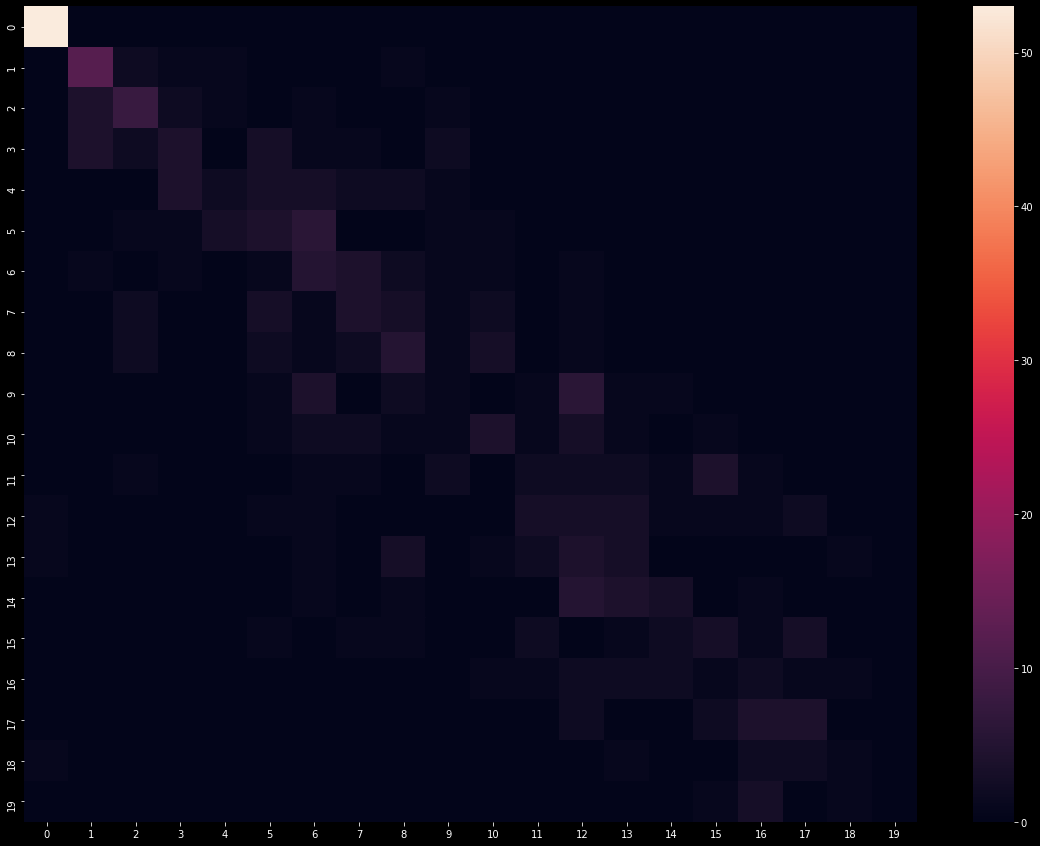

In [121]:
plt.figure(figsize = (20, 15))
sns.heatmap(confusion_matrix(y_test, y_pred))

In [122]:
output = x_test.copy()
output = output[['year', 'roundNum', 'raceId', 'driverId', 'constructorId', 'grid']]
output['y_pred'] = y_pred
output['y_actual'] = y_test
output = pd.merge(output, drivers[['driverId', 'fullName']], on = 'driverId', how = 'left')
output = pd.merge(output, constructors[['constructorId', 'name']], on = 'constructorId', how = 'left')
output = pd.merge(output, races[['raceId', 'name']], on = 'raceId', how = 'left')
output = output.rename(columns = {'year': 'Year', 'roundNum':'Round', 'grid': 'QualifyingGrid',
                                  'name_x': 'Constructor', 'name_y': 'GrandPrix', 'y_actual': 'FinalPosition',
                                  'y_pred': 'Prediction', 'fullName': 'Driver'}, inplace = False)
output = output[['Year', 'Round', 'GrandPrix', 'Constructor', 'Driver', 'QualifyingGrid', 'FinalPosition', 'Prediction']]
output
# output.to_csv('output.csv', index = False)

Year  Round             GrandPrix   Constructor              Driver  \
0    2020      1   Austrian Grand Prix      Mercedes     Valtteri Bottas   
1    2020      1   Austrian Grand Prix       Ferrari     Charles Leclerc   
2    2020      1   Austrian Grand Prix       McLaren        Lando Norris   
3    2020      1   Austrian Grand Prix      Mercedes      Lewis Hamilton   
4    2020      1   Austrian Grand Prix       McLaren        Carlos Sainz   
..    ...    ...                   ...           ...                 ...   
335  2020     17  Abu Dhabi Grand Prix    Alfa Romeo  Antonio Giovinazzi   
336  2020     17  Abu Dhabi Grand Prix      Williams     Nicholas Latifi   
337  2020     17  Abu Dhabi Grand Prix  Haas F1 Team     Kevin Magnussen   
338  2020     17  Abu Dhabi Grand Prix  Haas F1 Team   Pietro Fittipaldi   
339  2020     17  Abu Dhabi Grand Prix  Racing Point        Sergio Pérez   

     QualifyingGrid  FinalPosition  Prediction  
0                 1              1           1  
1                 7              2           2  
2                 3              3           3  
3                 5              4           5  
4                 8              5           5  
..              ...            ...         ...  
335              14             16          12  
336              18             17          16  
337              20             18          13  
338              17             19          18  
339              19              0           0  

[340 rows x 8 columns]

In [123]:
podium = []

for x in data['finishingPos']:
    if x == 1:
        podium.append(1)
    elif x == 2:
        podium.append(1)
    elif x == 3:
        podium.append(1)
    else:
        podium.append(0)

data['podium'] = podium

In [124]:
train = data[data['year']<2020]
test = data[data['year']>2019]

x_train = train.drop(['finishingPos', 'podium'], axis = 1)
y_train = train['podium']

x_test = test.drop(['finishingPos', 'podium'], axis = 1)
y_test = test['podium']

In [125]:
xgb_model = xgb.XGBClassifier(n_estimators = 100, random_state = 0, seed = None, silent = True, subsample = 0.6)
xgb_model.fit(x_train, y_train)

[00:37:54] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0,
              silent=True, subsample=0.6, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [126]:
y_pred = xgb_model.predict(x_test)

In [127]:
print('Model Accuracy is {}'.format(accuracy_score(y_test, y_pred)*1e2))
print(classification_report(y_test, y_pred))

Model Accuracy is 92.05882352941175
              precision    recall  f1-score   support

           0       0.94      0.97      0.95       289
           1       0.80      0.63      0.70        51

    accuracy                           0.92       340
   macro avg       0.87      0.80      0.83       340
weighted avg       0.92      0.92      0.92       340



<AxesSubplot:>

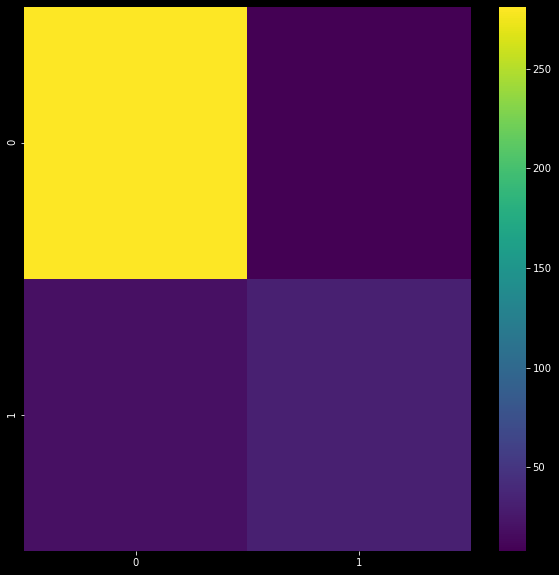

In [128]:
plt.figure(figsize = (10, 10))
sns.heatmap(confusion_matrix(y_test, y_pred), cmap = "viridis")

In [129]:
output = x_test.copy()
output = output[['year', 'roundNum', 'raceId', 'driverId', 'constructorId', 'grid']]
output['y_pred'] = y_pred
output['y_actual'] = y_test
output = pd.merge(output, drivers[['driverId', 'fullName']], on = 'driverId', how = 'left')
output = pd.merge(output, constructors[['constructorId', 'name']], on = 'constructorId', how = 'left')
output = pd.merge(output, races[['raceId', 'name']], on = 'raceId', how = 'left')
output = output.rename(columns = {'year': 'Year', 'roundNum':'Round', 'grid': 'QualifyingGrid',
                                  'name_x': 'Constructor', 'name_y': 'GrandPrix', 'y_actual': 'FinalPosition',
                                  'y_pred': 'Prediction', 'fullName': 'Driver'}, inplace = False)
output = output[['Year', 'Round', 'GrandPrix', 'Constructor', 'Driver', 'QualifyingGrid', 'FinalPosition', 'Prediction']]
output
# output.to_csv('output.csv', index = False)

Year  Round             GrandPrix   Constructor              Driver  \
0    2020      1   Austrian Grand Prix      Mercedes     Valtteri Bottas   
1    2020      1   Austrian Grand Prix       Ferrari     Charles Leclerc   
2    2020      1   Austrian Grand Prix       McLaren        Lando Norris   
3    2020      1   Austrian Grand Prix      Mercedes      Lewis Hamilton   
4    2020      1   Austrian Grand Prix       McLaren        Carlos Sainz   
..    ...    ...                   ...           ...                 ...   
335  2020     17  Abu Dhabi Grand Prix    Alfa Romeo  Antonio Giovinazzi   
336  2020     17  Abu Dhabi Grand Prix      Williams     Nicholas Latifi   
337  2020     17  Abu Dhabi Grand Prix  Haas F1 Team     Kevin Magnussen   
338  2020     17  Abu Dhabi Grand Prix  Haas F1 Team   Pietro Fittipaldi   
339  2020     17  Abu Dhabi Grand Prix  Racing Point        Sergio Pérez   

     QualifyingGrid  FinalPosition  Prediction  
0                 1              1           1  
1                 7              1           1  
2                 3              1           1  
3                 5              0           0  
4                 8              0           0  
..              ...            ...         ...  
335              14              0           0  
336              18              0           0  
337              20              0           0  
338              17              0           0  
339              19              0           0  

[340 rows x 8 columns]